In [1]:
#import packages
import pandas as pd
import sys
import matplotlib.pyplot as plt
from datetime import datetime
import logging
import numpy as np
import copy

#custom classes
from classes import classes as cl
from functions import functions as fc
from functions import routing as rt
from functions import simulated_annealing as sa

plt.rcParams.update({'font.size': 22})
logging.basicConfig(filename="sa_lvl.log", level=logging.INFO)

init_path = 'output/initial_solution'
img_exp_path = 'output/graphs/sa_lvl/'

Initiation

In [2]:
fc.print_log("Starting initiation")
#create empty dict
initiation_objects = {'dict_depots': '', 'dict_sites': '', 'dict_plants': '', 'dict_jobs': '', 'dict_tours': '', 'list_days': ''}


objects = fc.initiate(initiation_objects,init_path,'final')

#load objects
list_days = objects['list_days']
dict_depots = objects['dict_depots']
dict_sites = objects['dict_sites']
dict_plants = objects['dict_plants']
dict_jobs = objects['dict_jobs']
dict_tours = objects['dict_tours']

#also create lists for convenience
list_depots = [dict_depots[element] for element in dict_depots]
list_sites = [dict_sites[element] for element in dict_sites]
list_plants = [dict_plants[element] for element in dict_plants]
list_jobs = [dict_jobs[element] for element in dict_jobs]
list_tours  = [dict_tours[element] for element in dict_tours]


fc.print_log("Done with initiation")

Starting initiation- t: 22:45:33
Starting initiation at 22:45:33- t: 22:45:33
Done with initiation- t: 22:45:34


In the first stage only one depot ist handled, so moves so its all about dropoff and pickup dates

In [3]:
#ov tours
for depot in dict_depots:
    total_tasks = 0
    total_distance = 0
    for day in list_days:
        total_tasks += dict_tours[depot][day].total_tasks
        total_distance += dict_tours[depot][day].distance
    print("Depot: {}, tasks: {} - distance: {}".format(depot,total_tasks,total_distance))

print("done here")

Depot: Neuherberg, tasks: 25454 - distance: 4547134.5148212565
Depot: Lauterhofen, tasks: 14329 - distance: 2151298.5445965845
Depot: Altbach, tasks: 5534 - distance: 648999.0083624776
Depot: Deisslingen, tasks: 0 - distance: 0
Depot: Bollschweil, tasks: 1586 - distance: 167723.71699792094
Depot: Lampertheim, tasks: 5872 - distance: 1059256.2914196497
Depot: Neuss, tasks: 19062 - distance: 2374315.453137417
Depot: Embsen, tasks: 9216 - distance: 1121736.368534145
Depot: Rottleberode, tasks: 25304 - distance: 6393335.900862845
Depot: Fenne, tasks: 0 - distance: 0
Depot: Castrop, tasks: 0 - distance: 0
Depot: Perl, tasks: 0 - distance: 0
Depot: Gnetsch, tasks: 0 - distance: 0
Depot: Vogelsdorf, tasks: 0 - distance: 0
Depot: Sukow, tasks: 0 - distance: 0
done here


start here
Start Inital Solution Plot- t: 22:45:34
Done with  Inital Solution Plot- t: 22:45:45


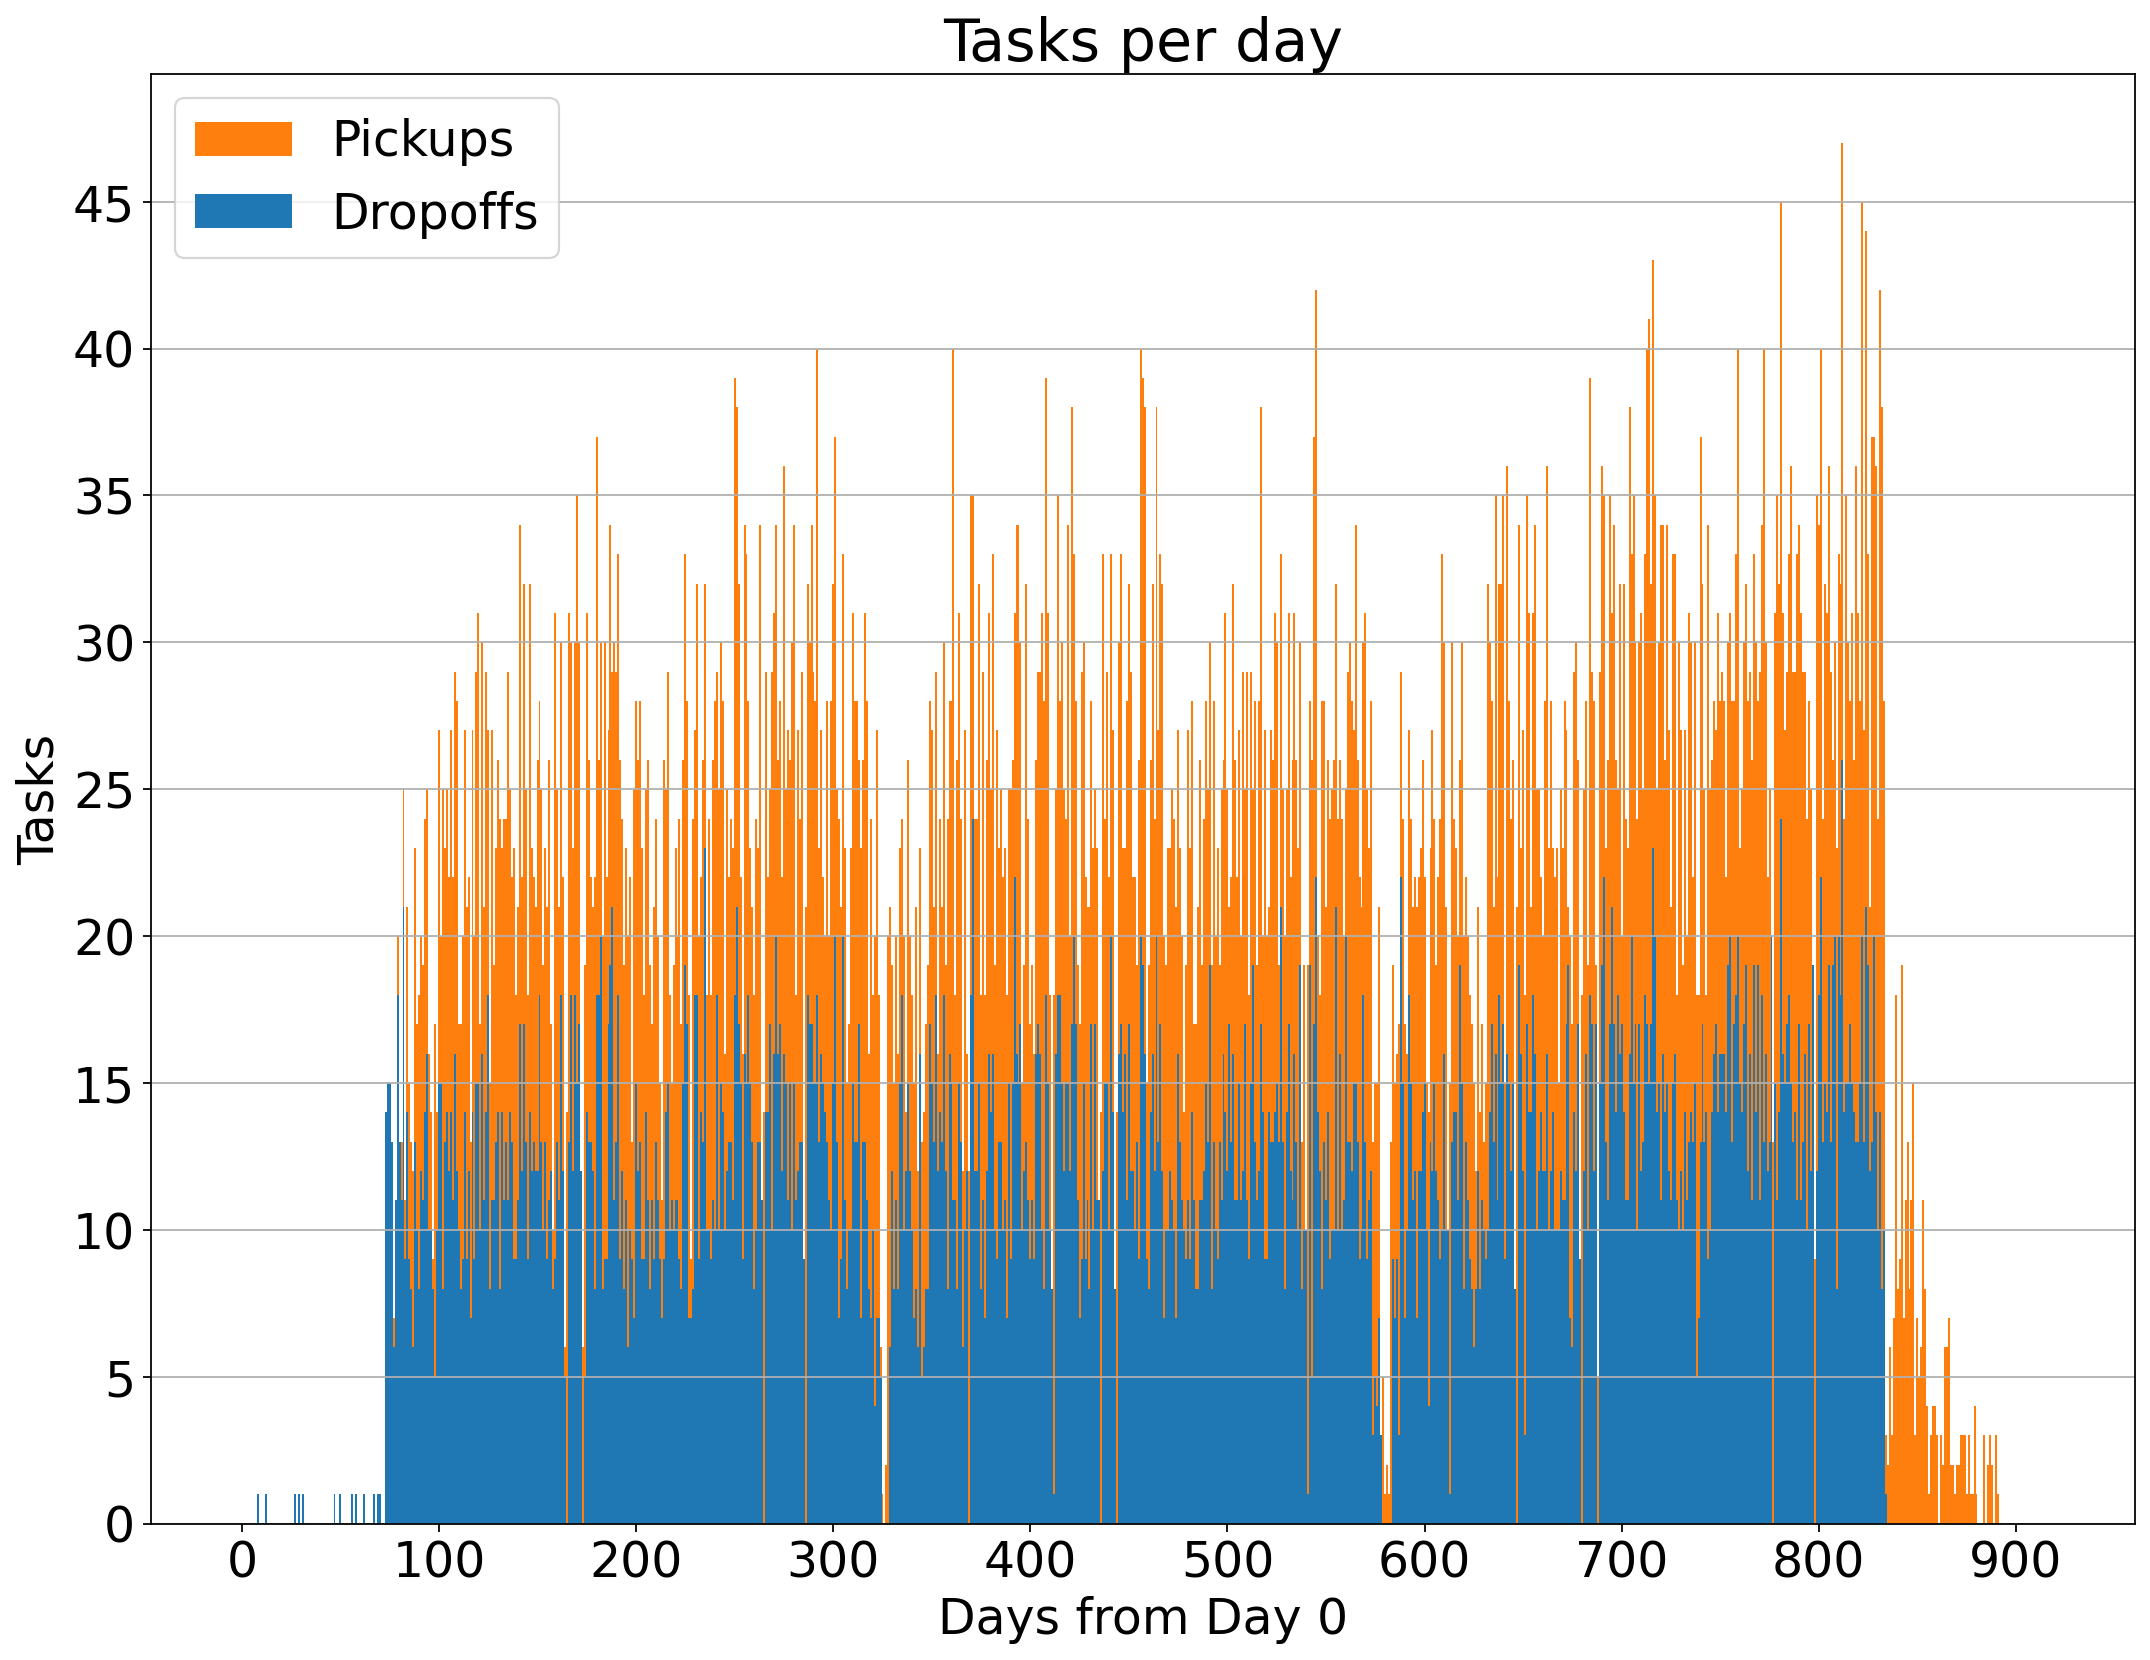

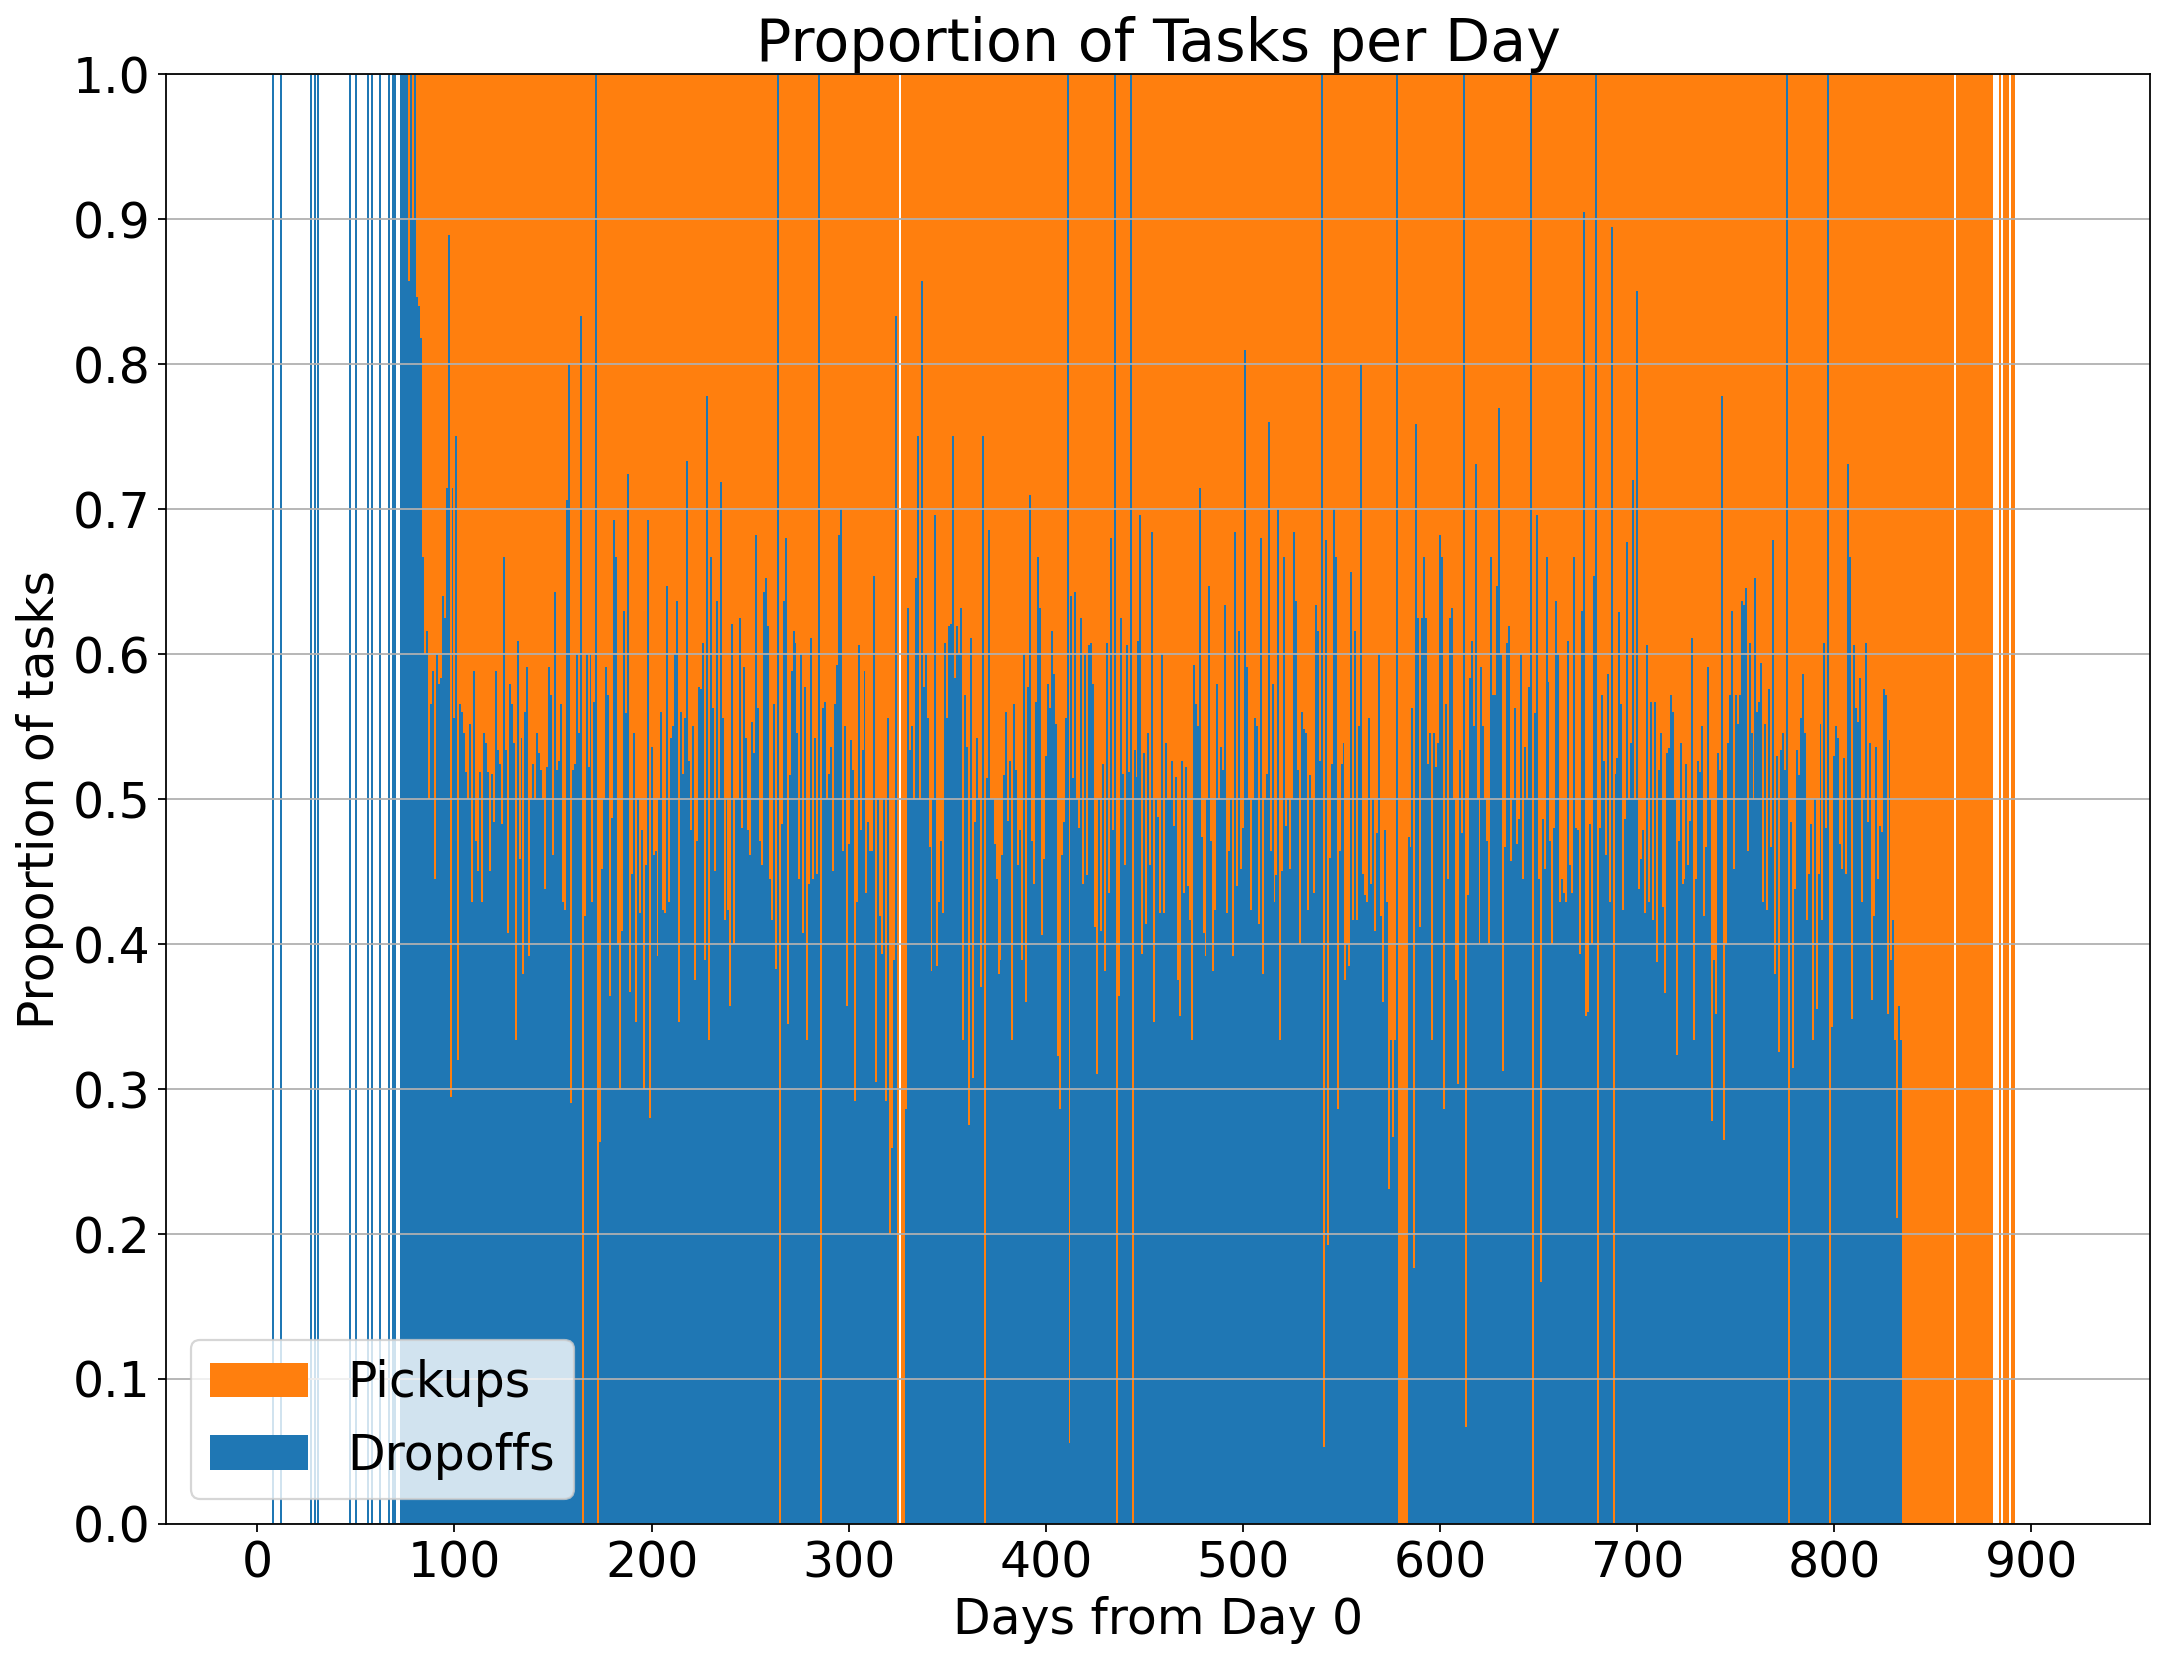

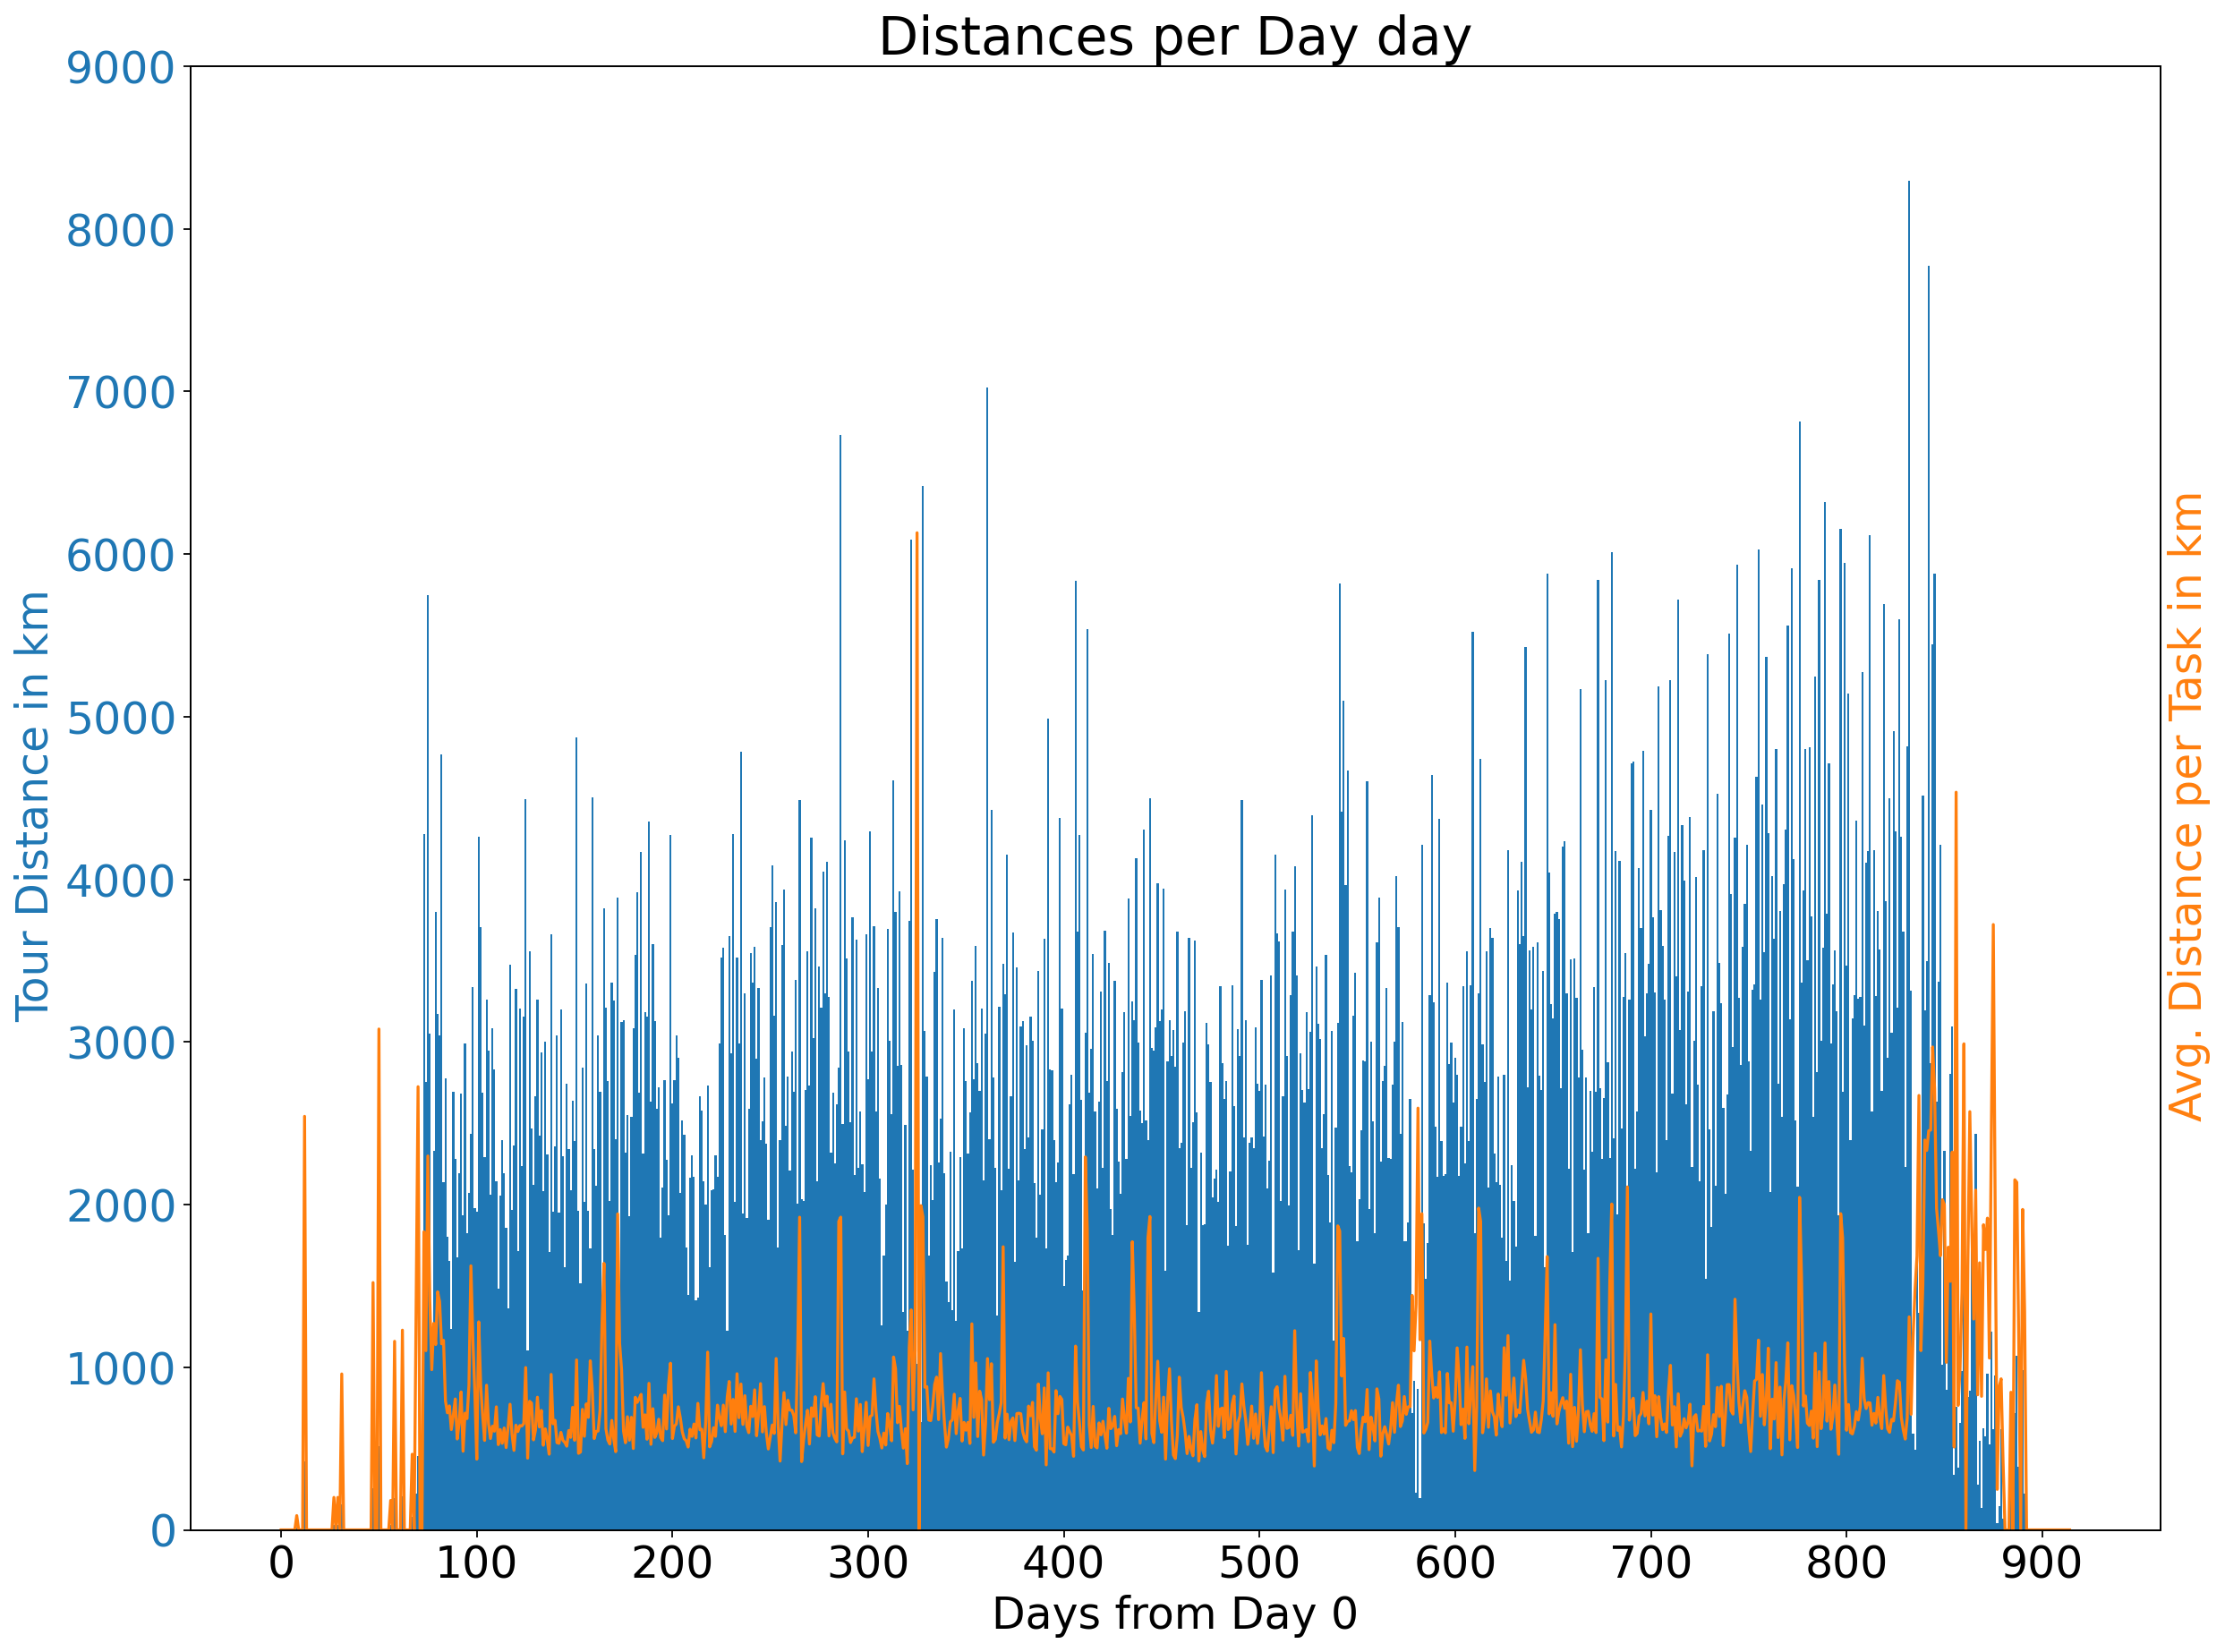

In [4]:
print("start here")
fc.print_log("Start Inital Solution Plot")

#only work with one depot
temp_depot = dict_depots['Neuss']
list_depots = [temp_depot]
dict_depots = {'Neuss': temp_depot}



solution_initial = cl.Solution(temp_depot,dict_tours,list_days)

solution_initial.plot_tasks(50,exp_prefix = img_exp_path + 'solution_inital_')
solution_initial.plot_task_proportion(exp_prefix = img_exp_path + 'solution_inital_')
solution_initial.plot_distances(10000,1500,exp_prefix = img_exp_path + 'solution_inital_')

fc.print_log("Done with  Inital Solution Plot")


After having a look at the inital solution, start optimizing

Stage 1: Try to level out the proportions between dropoff and pickup on eatch job

Start with Stage 1a- t: 22:45:45
2594.8802766529147
Start Moves- t: 22:45:45
Final: Loop: 1362 - Moves: 1362- t: 22:49:22                       
Done with Moves- t: 22:49:22
Done with Stage 1a- t: 22:49:32


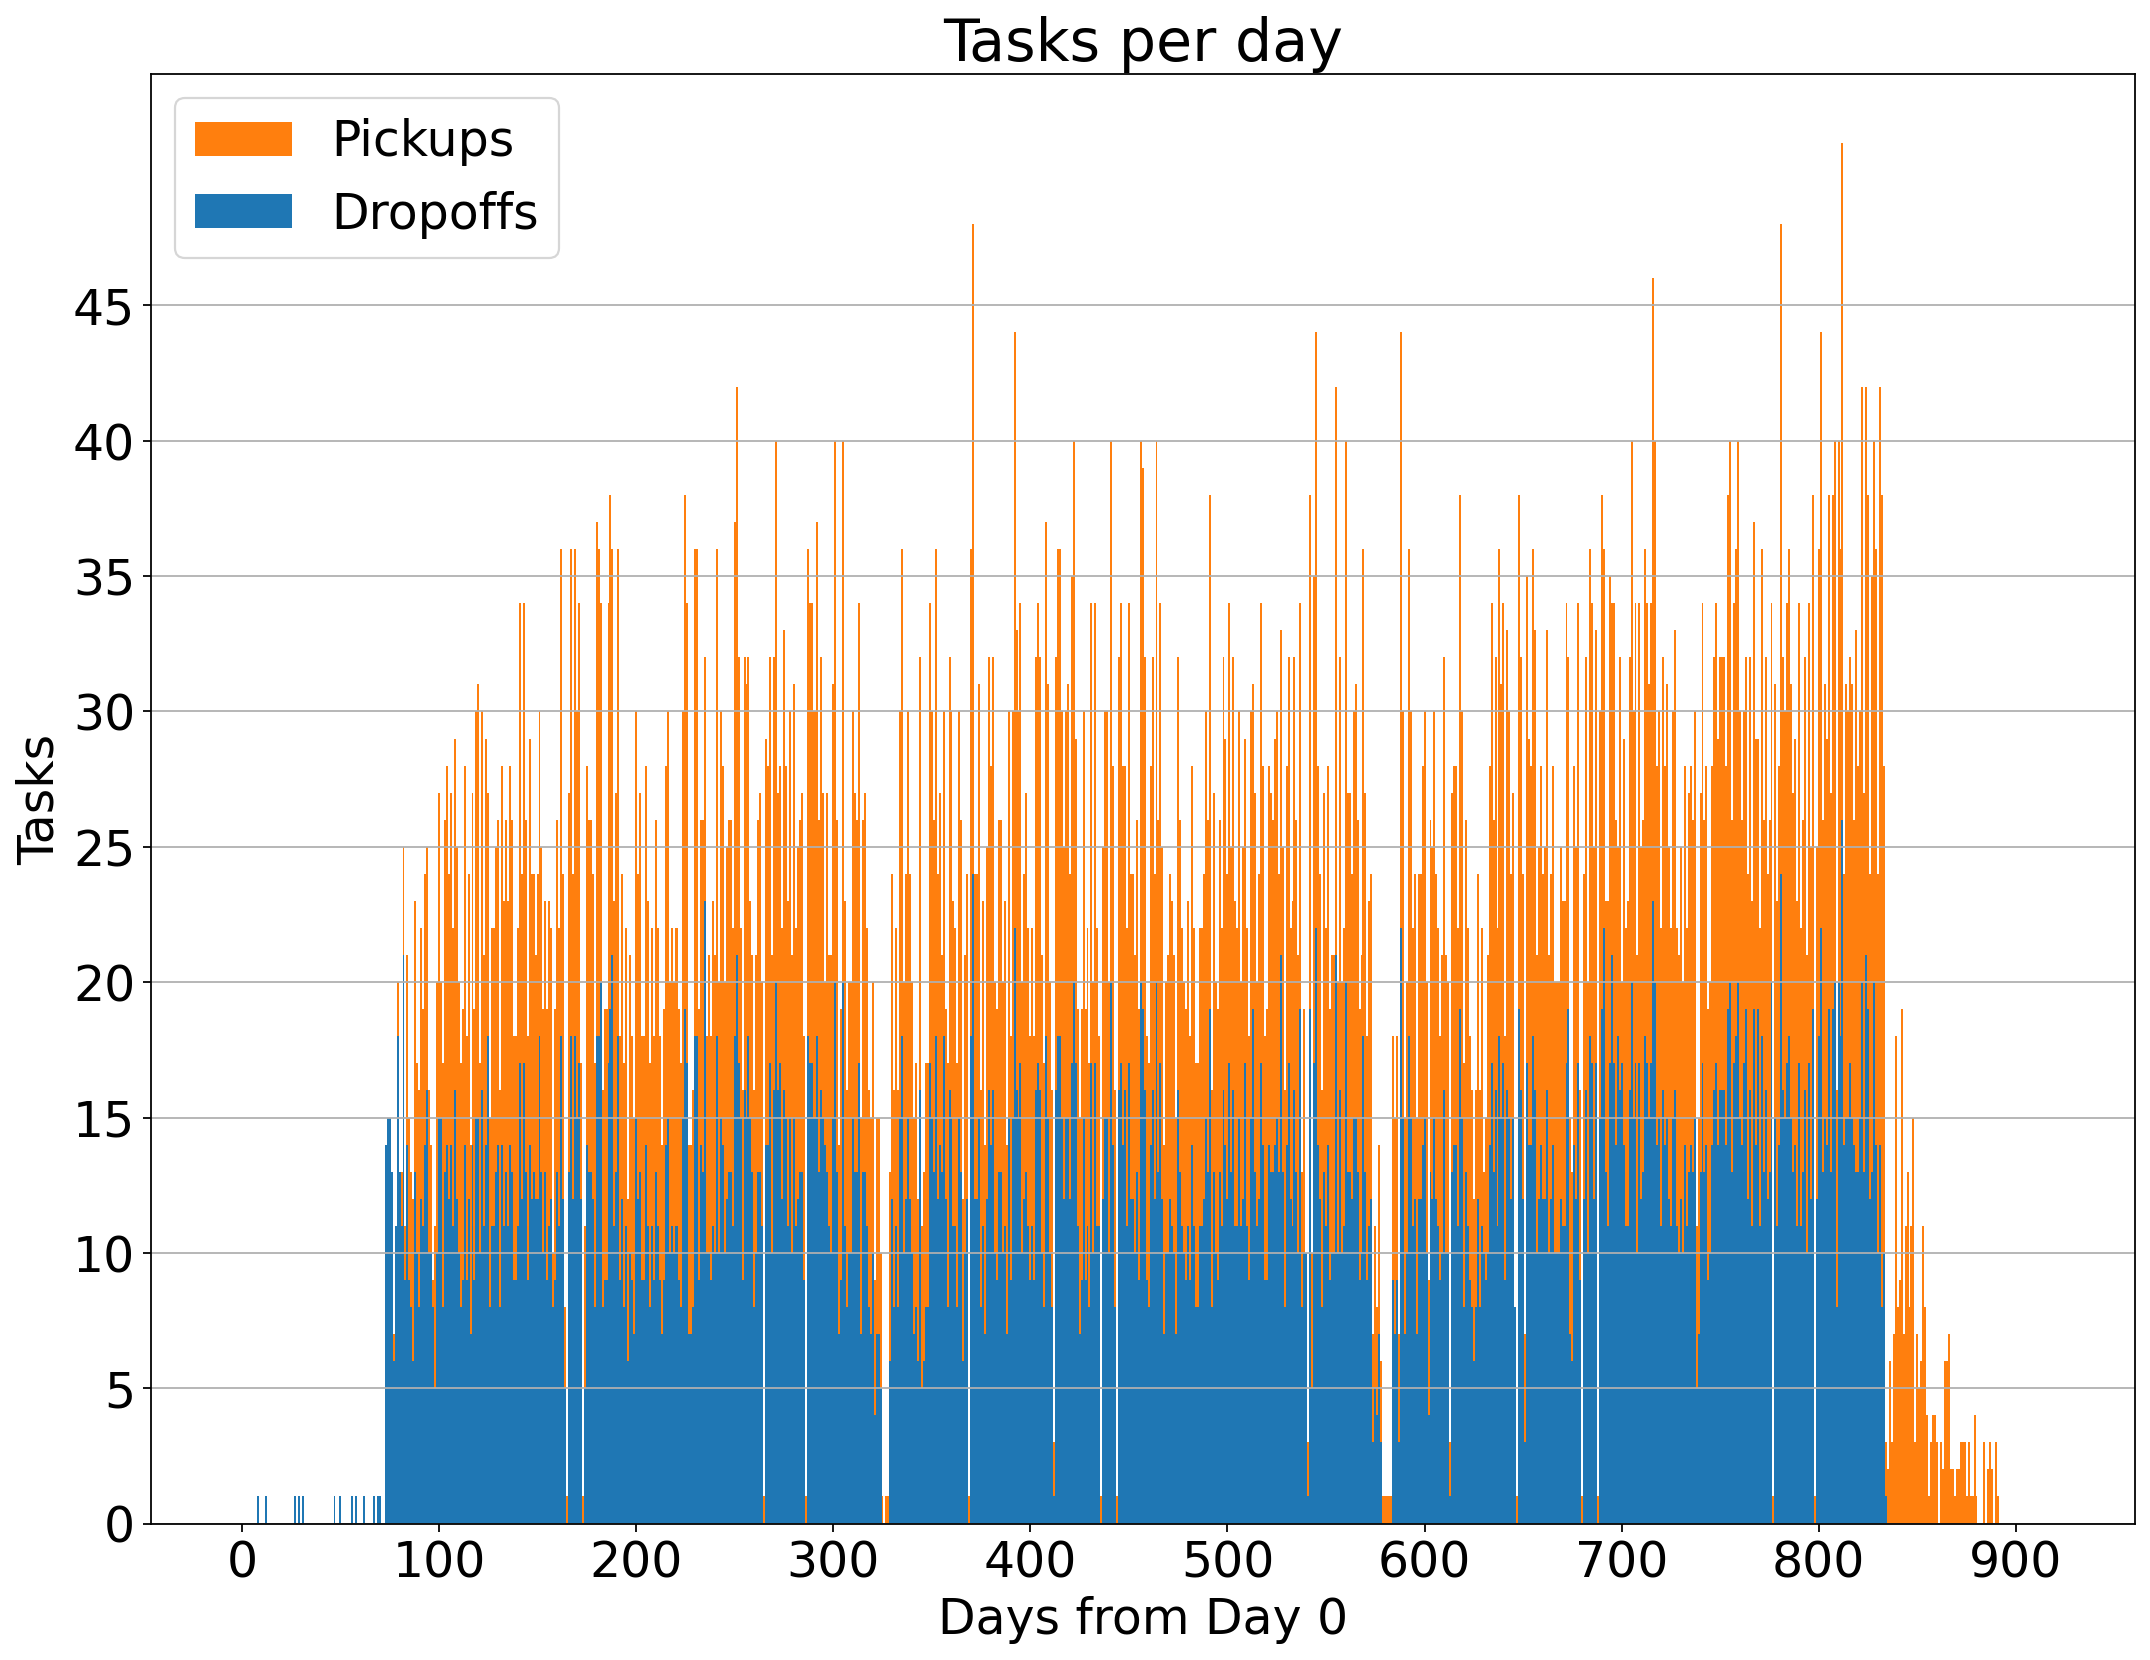

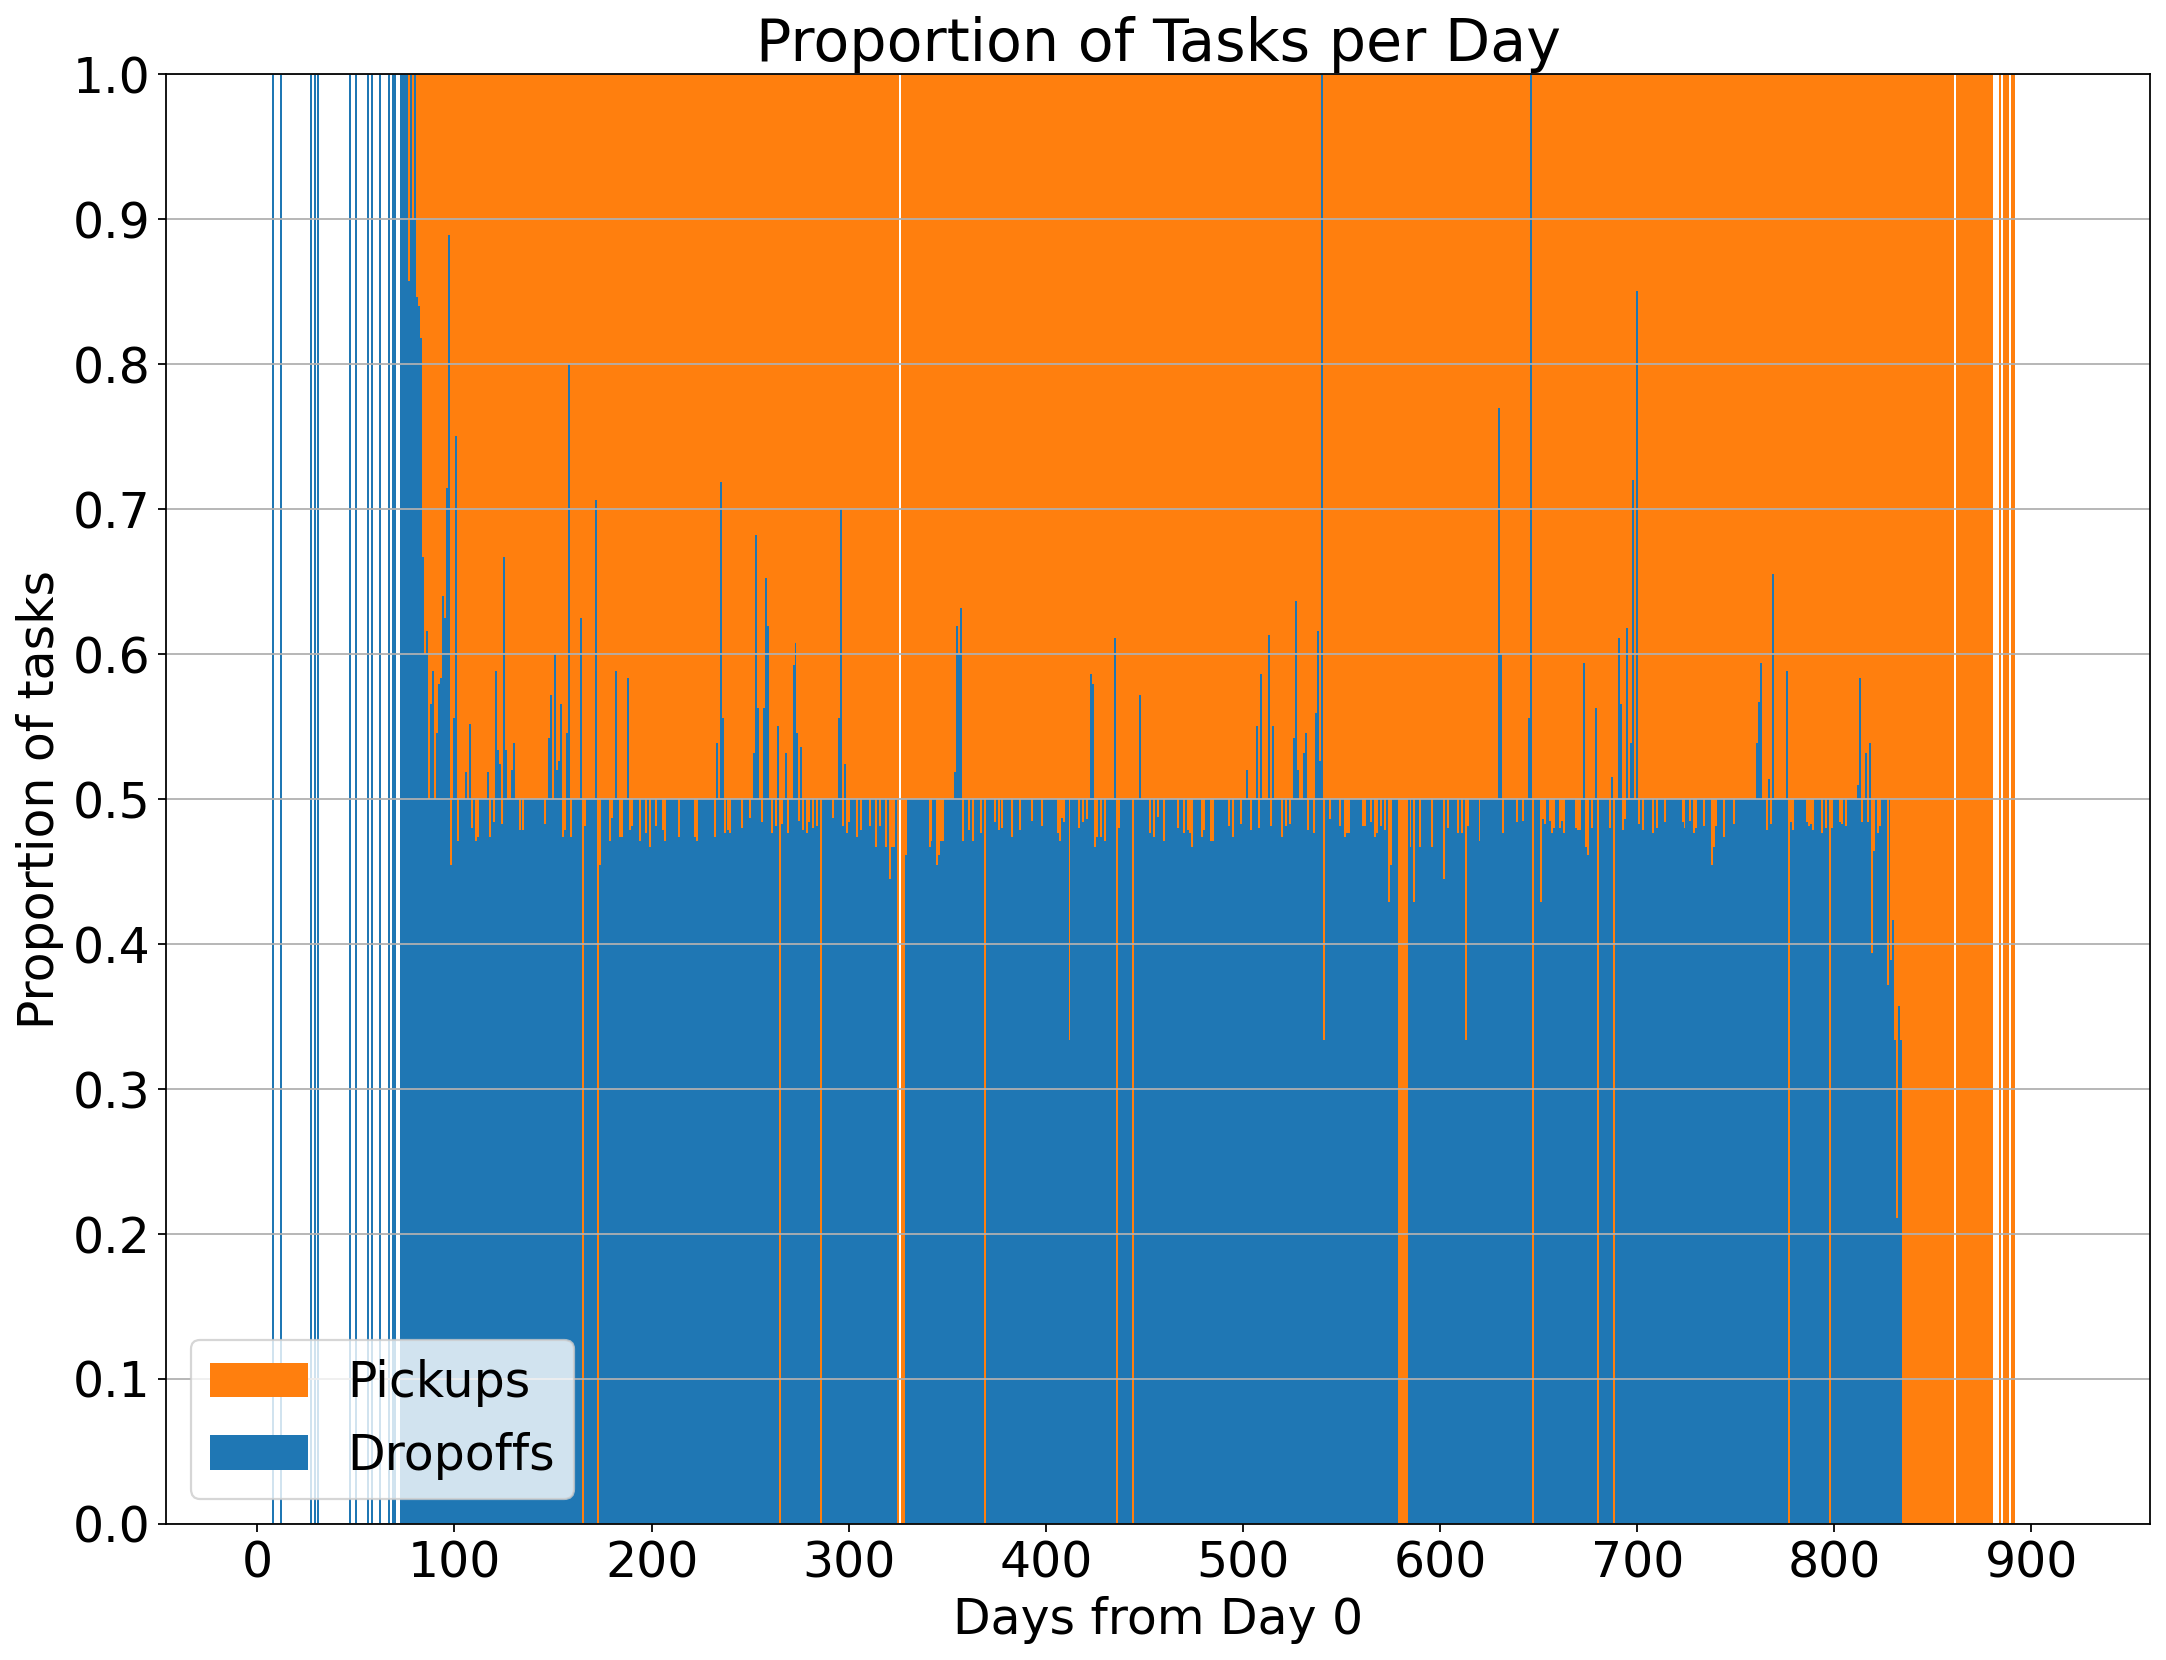

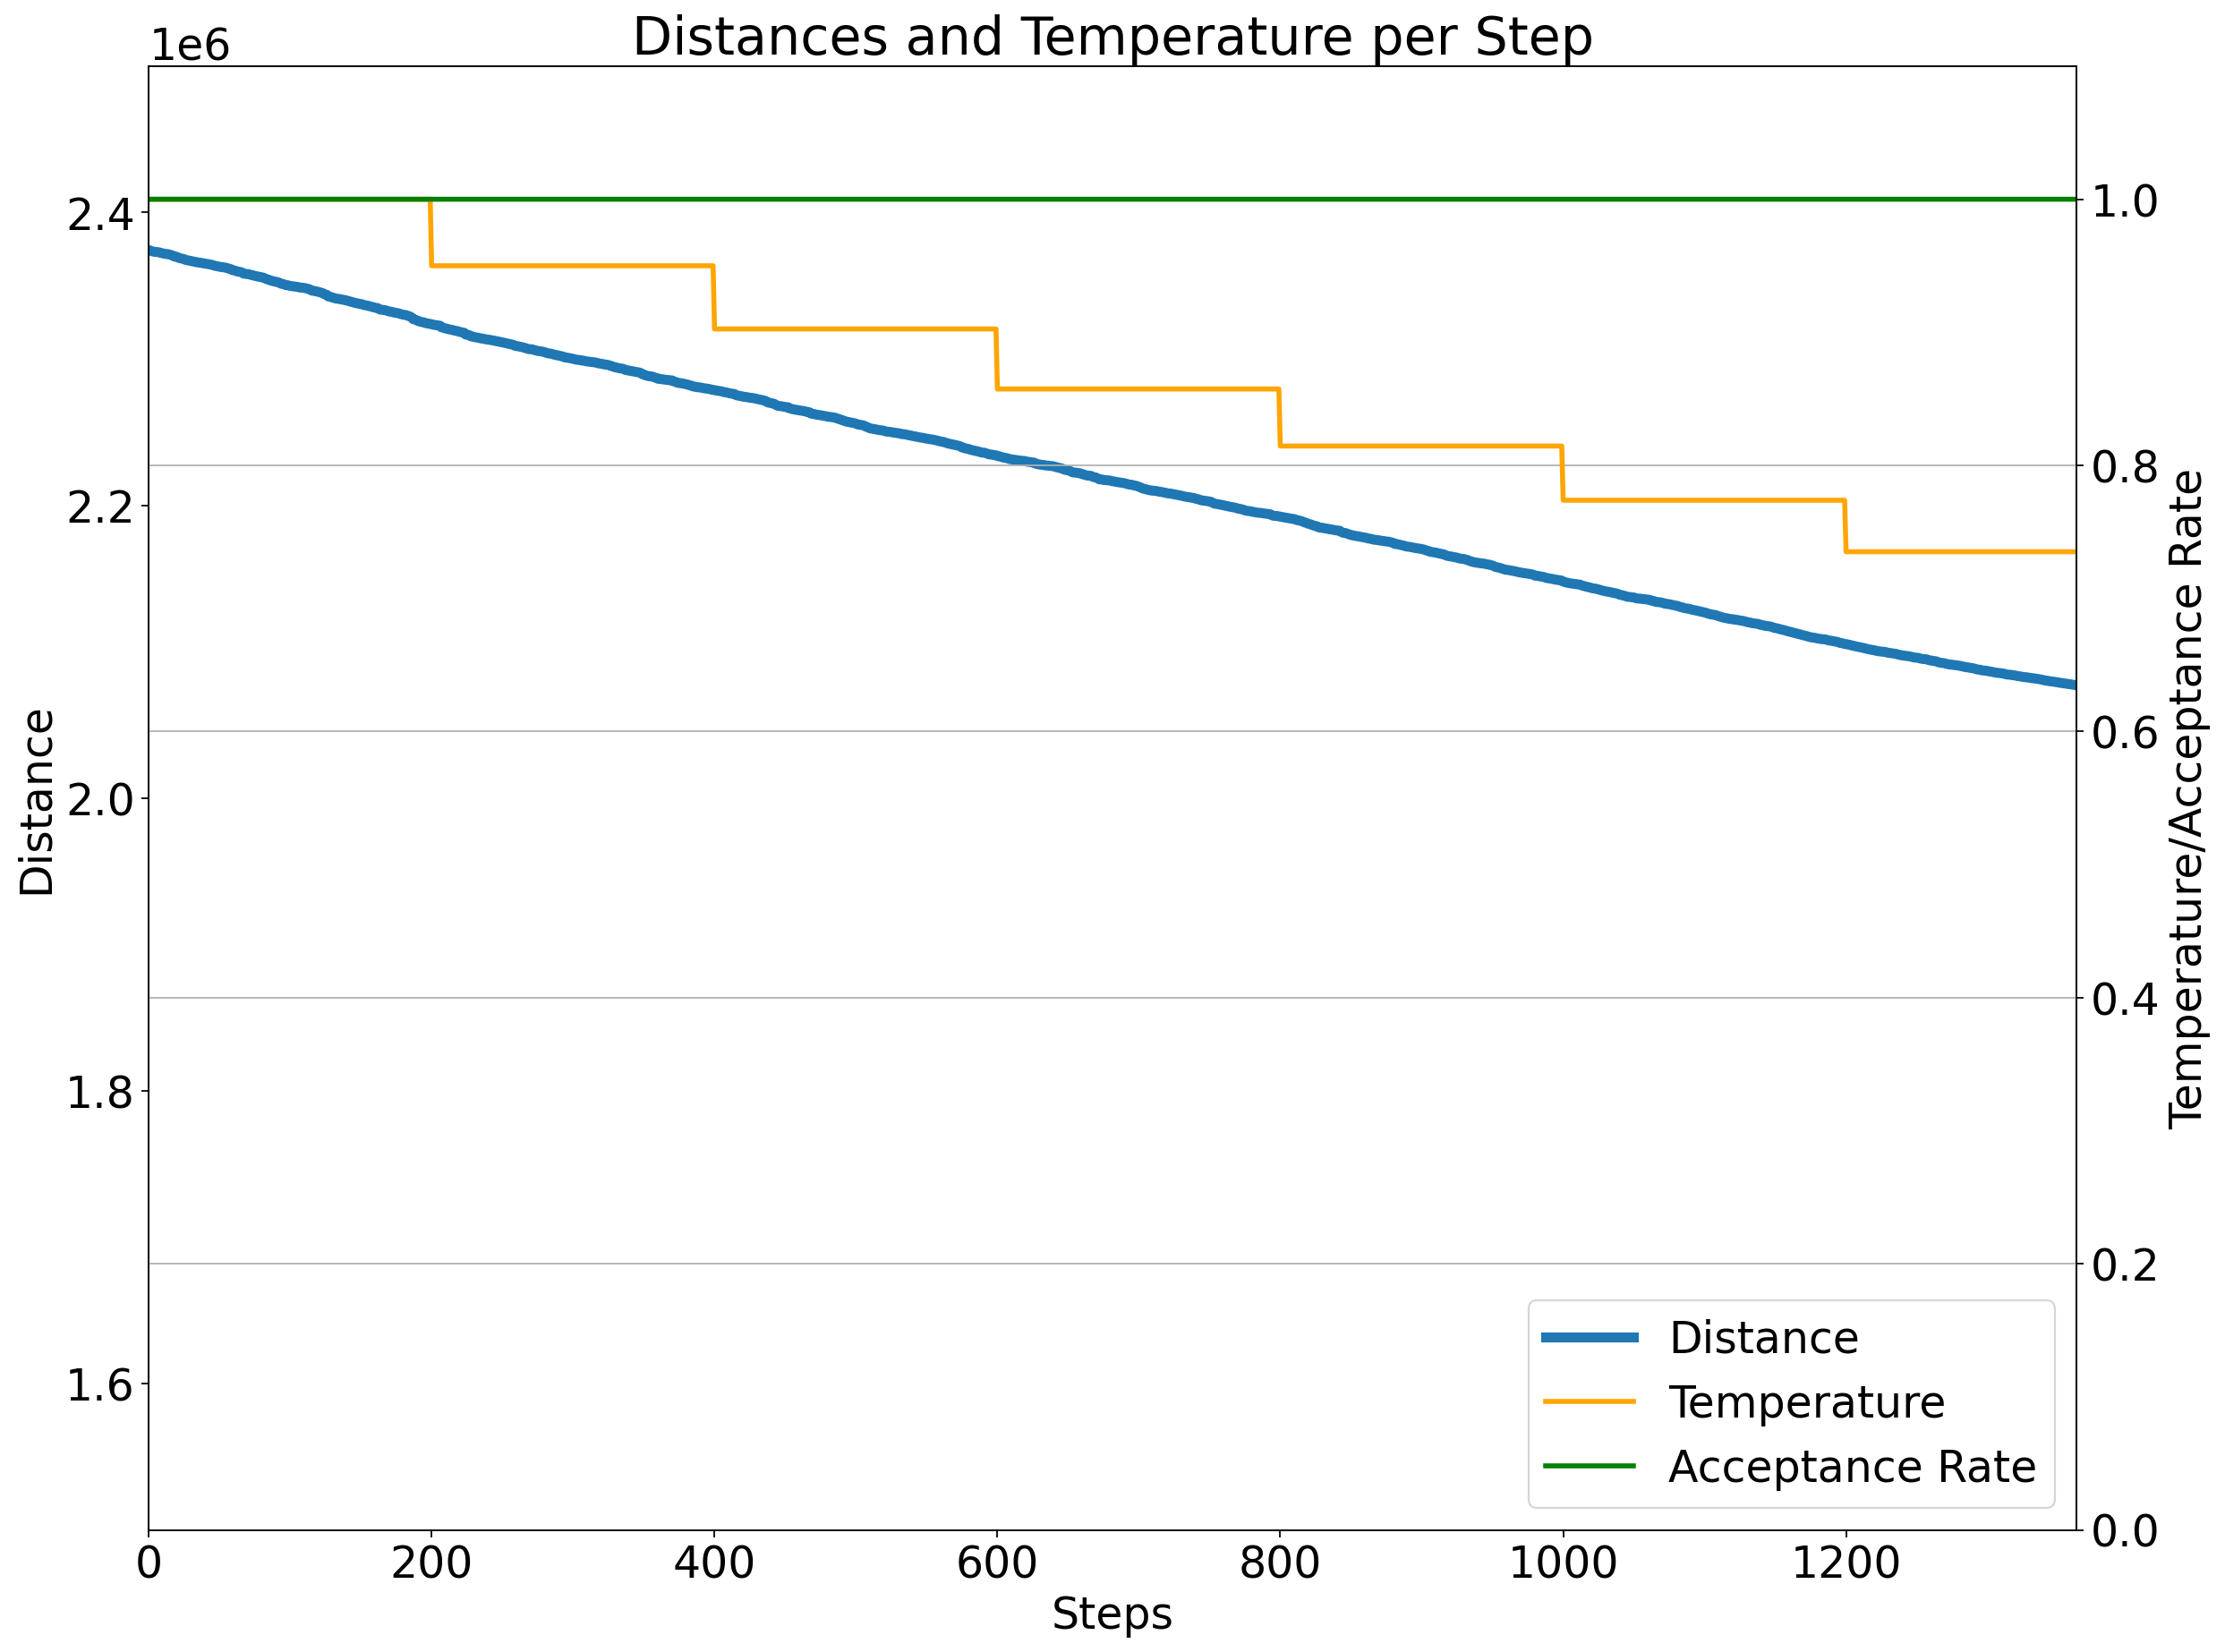

In [5]:
fc.print_log("Start with Stage 1a")
#dict_tours_temp = copy.deepcopy(dict_tours)
dict_tours_temp = dict_tours
moves_possible = True
move_count = 0
step_count = 0
step_count_curr = 0

#define temperature schedule
temperature = sa.Geometric_Schedule(1,0.95,200)
current_temp = temperature.temp_initial
#define acceptance
avg_tour_length = solution_initial.total_distance / len(list_days)
print(avg_tour_length)
acceptance = sa.NormalizedExponentialAcceptance(avg_tour_length)
#define overall statistic
dict_statistic = {0: [solution_initial.total_distance, temperature.temp_initial,0,0]}



fc.print_log("Start Moves")
while moves_possible and step_count < 10000:
    move_made = False
    for depot in dict_depots:
        for day_org in list_days:

            #see if there are too many pickups in one job
            tour_org = dict_tours_temp[depot][day_org]

            if tour_org.total_pickups > tour_org.total_dropoffs:
                if tour_org.worst_edge_pickup != '':
                    move_job = tour_org.worst_edge_pickup
                    #see if there is space for a pickup, and check if it works with the earliest pickup date of the job
                    for day_new in list_days:
                        tour_new = dict_tours_temp[depot][day_new]
                        if tour_new.total_pickups < tour_new.total_dropoffs\
                                and move_job.end < day_new:

                            #evaluate move
                            distance_delta = sa.evaluate_pickup(tour_org,tour_new,move_job)

                            #check for acceptance - if accepted, reassign
                            if acceptance.get_acc(current_temp,distance_delta):

                                #perform move
                                distance_delta = sa.reassign_pickup(tour_org,tour_new,move_job)

                                #adjust move_bol, statistic and leave for loop
                                move_made = True
                                move_count +=1
                                step_count += 1
                                step_count_curr += 1
                                current_temp = temperature.get_temp(step_count_curr)

                                last_total_distance = dict_statistic[step_count-1][0]
                                dict_statistic[step_count] = [last_total_distance + distance_delta,\
                                                              current_temp, move_count, step_count]
                                break
                            else:
                                step_count += 1
                                last_total_distance = dict_statistic[step_count-1][0]
                                dict_statistic[step_count] = [last_total_distance + distance_delta,\
                                                              current_temp, move_count, step_count]
                                move_made = True
                                break


                print("Current: Loop: {} - Moves: {}                                  ".format(step_count,move_count),end='\r')
                if step_count > 10000: break



    moves_possible = move_made

    print("Current: Loop: {} - Moves: {}                                  ".format(step_count,move_count),end='\r')



fc.print_log("Final: Loop: {} - Moves: {}".format(step_count,move_count))

fc.print_log("Done with Moves")
solution_stage1a = cl.Solution(temp_depot,dict_tours_temp,list_days,dev_curr=dict_statistic, dev_tot_old =dict_statistic)

solution_stage1a.plot_tasks(50,exp_prefix = img_exp_path + 'solution_stage1a')
solution_stage1a.plot_task_proportion(exp_prefix = img_exp_path + 'solution_stage1a')
solution_stage1a.plot_developement(exp_prefix = img_exp_path + 'solution_stage1a')


fc.print_log("Done with Stage 1a")
steps_1a = step_count

In [6]:
print("old distance: %s" % solution_initial.total_distance)
print("new distance: %s" % solution_stage1a.total_distance)

old distance: 2374315.453137417
new distance: 2077207.3177647186


In [7]:
fc.print_log("Start with Stage 1b")

dict_tours_temp = dict_tours

list_days_reversed = list_days.copy()
list_days_reversed.reverse()


Start with Stage 1b- t: 22:49:32


2594.8802766529147
Start Moves- t: 22:49:32
Final: Loop: 1567 - Moves: 1567- t: 22:50:02                       
Done with Moves- t: 22:50:02
Done with Stage 1b- t: 22:50:10


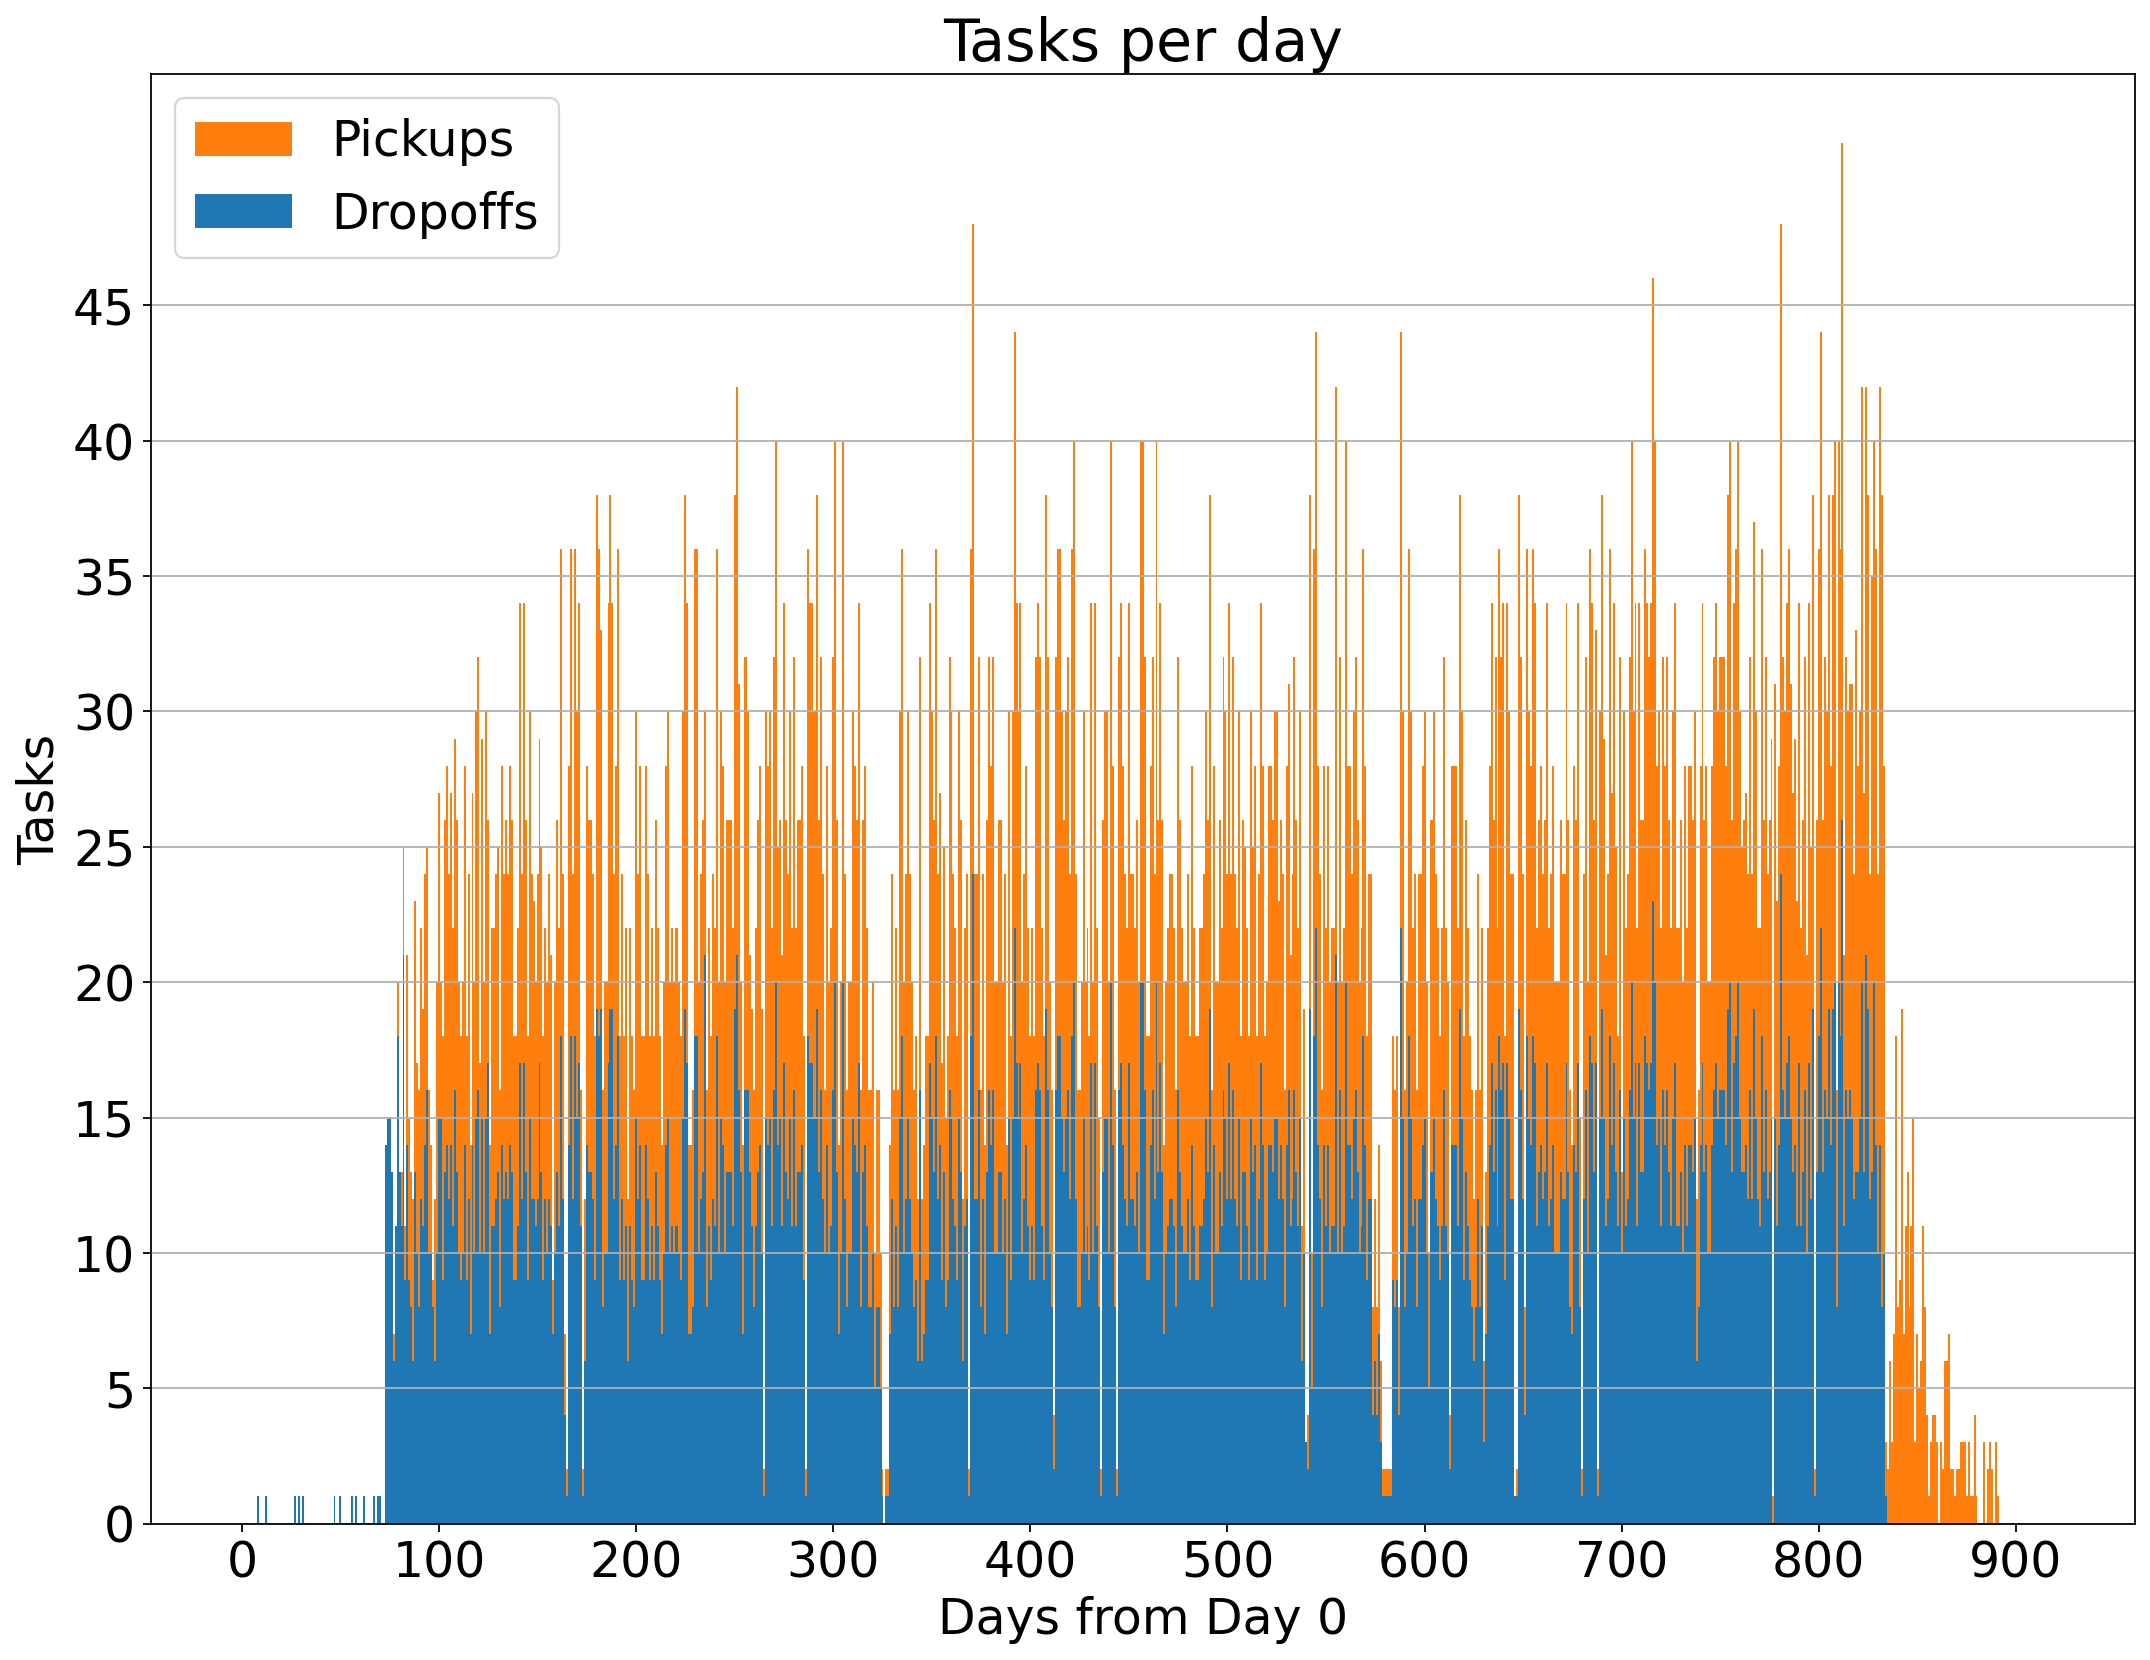

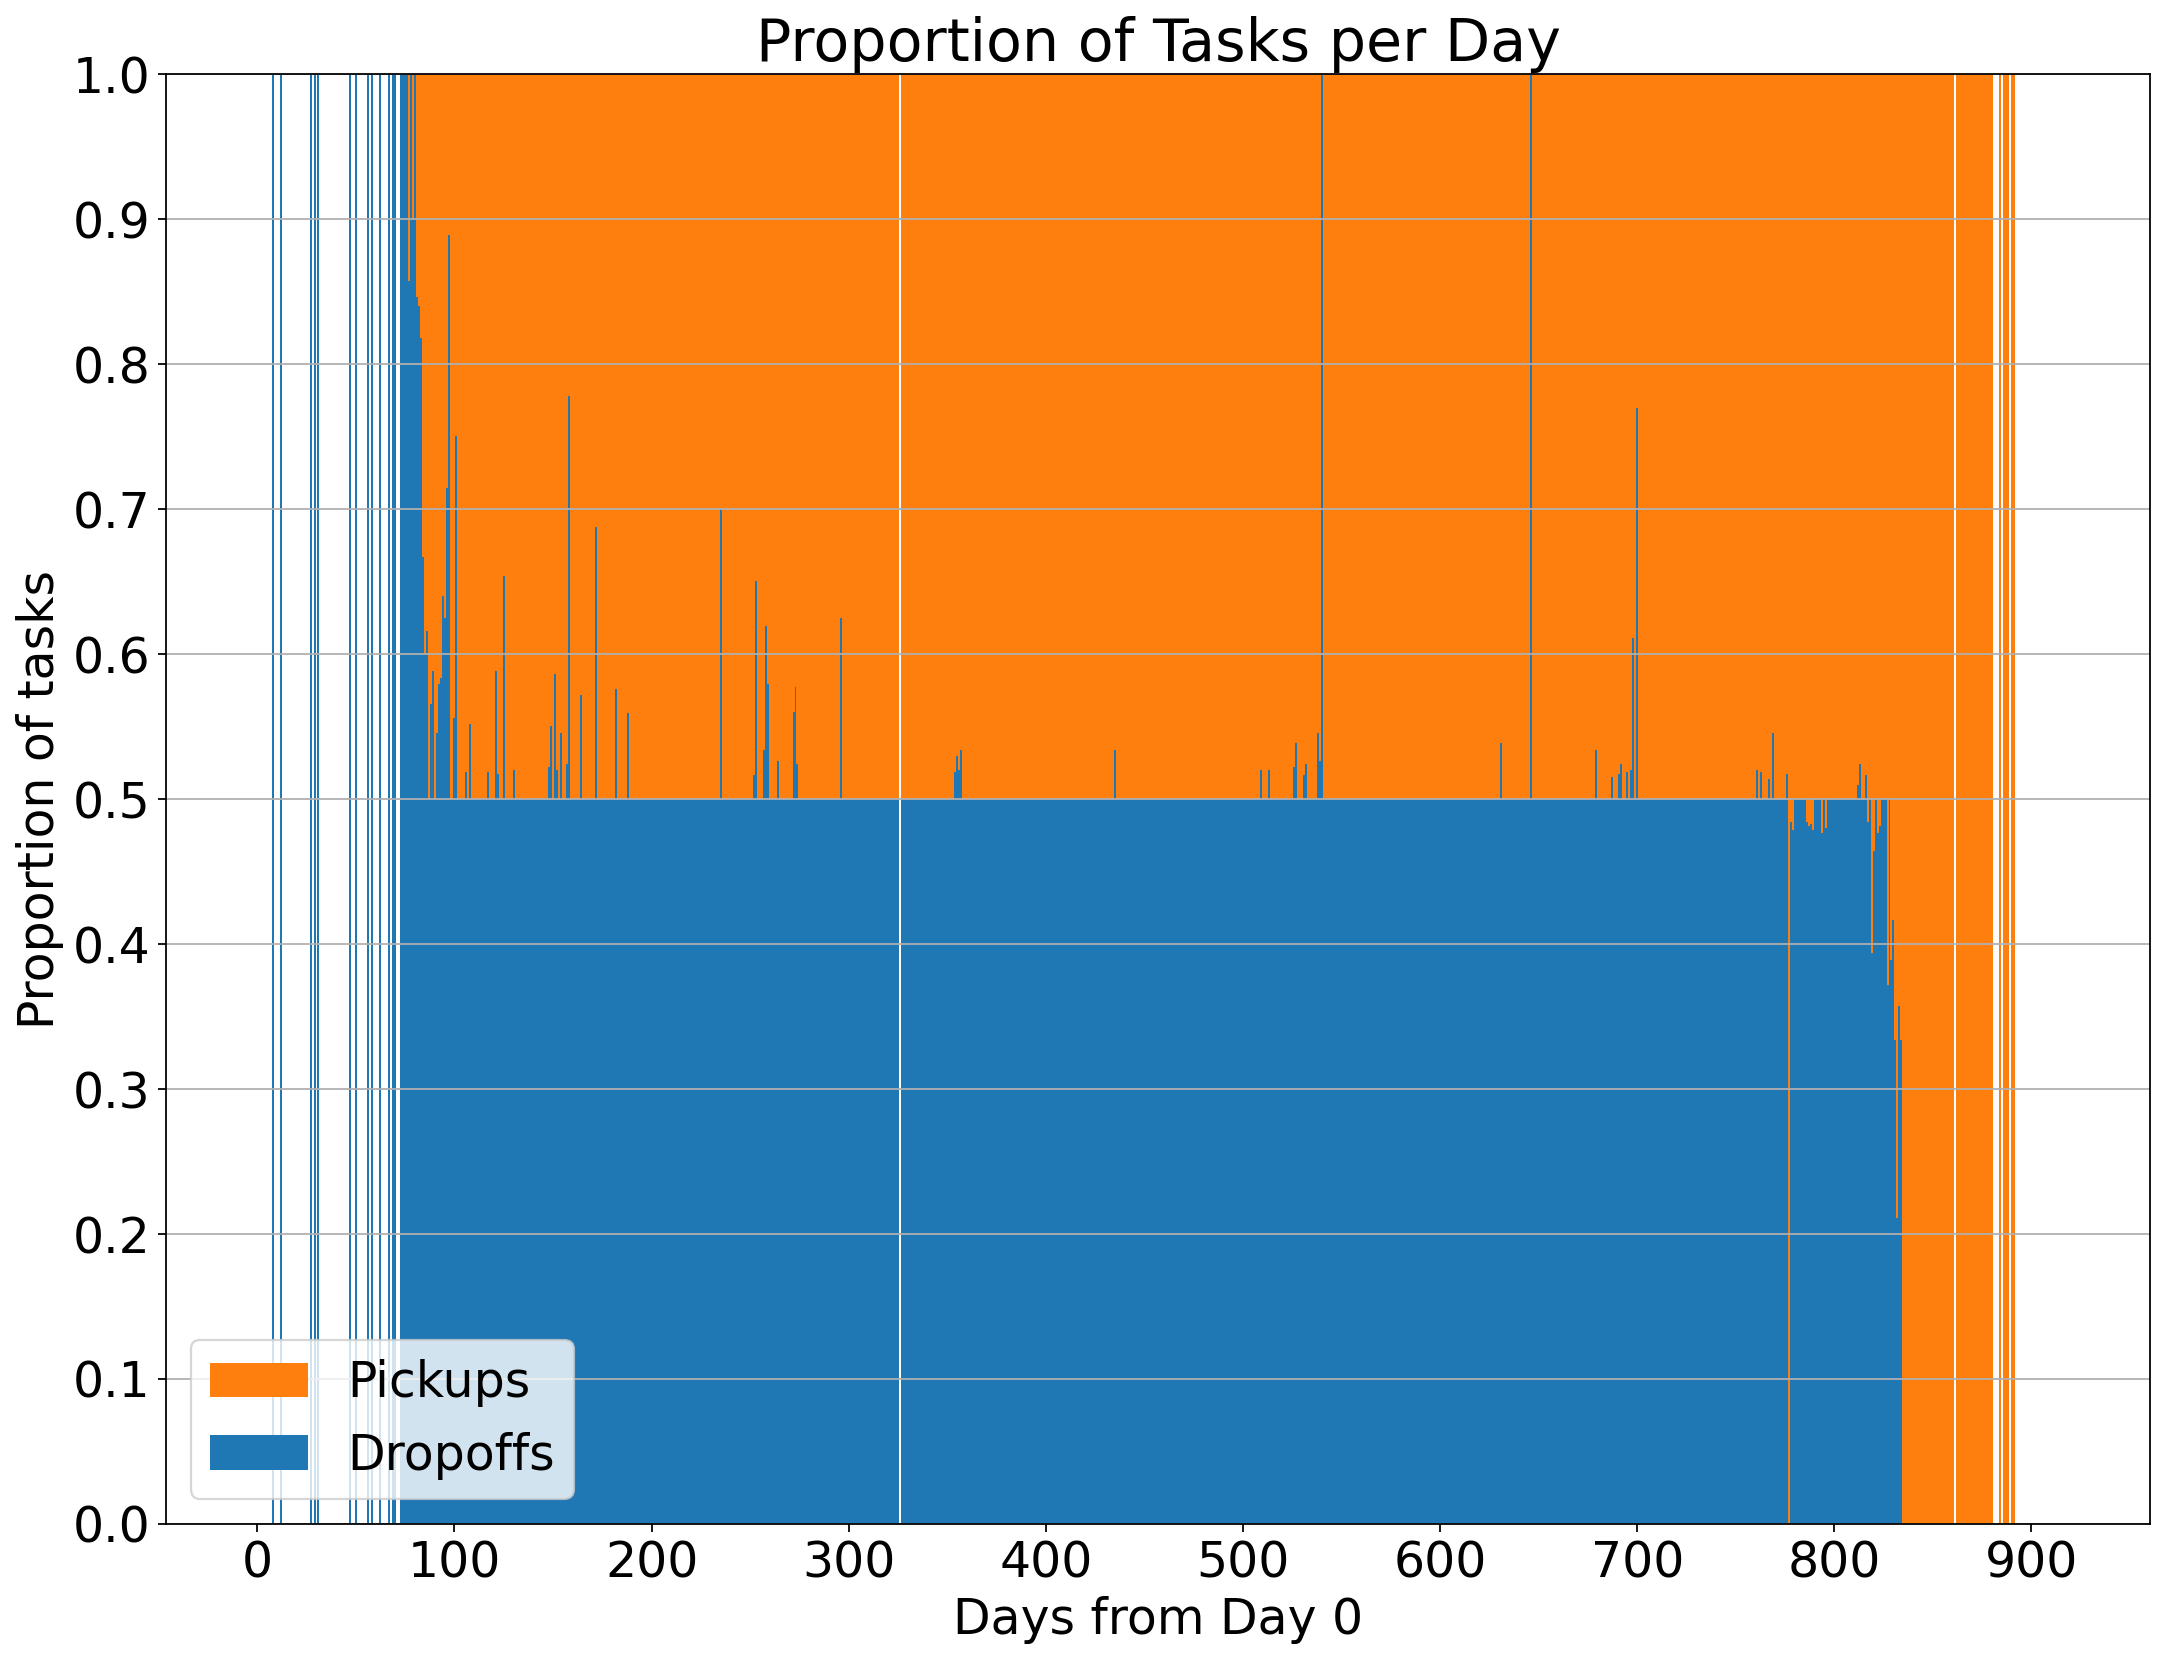

In [8]:
moves_possible = True
step_count = steps_1a

#define temperature schedule
temperature = sa.Geometric_Schedule(1,0.95,200)
current_temp = temperature.temp_initial
#define acceptance function
avg_tour_length = solution_initial.total_distance / len(list_days)
print(avg_tour_length)
acceptance = sa.NormalizedExponentialAcceptance(avg_tour_length)
#define temp staistic
step_count_curr = 0
dict_statistic_curr = {0: [solution_stage1a.total_distance, temperature.temp_initial]}
moves_possible = True


fc.print_log("Start Moves")
while moves_possible and step_count < 10000:
    moves_possible = False
    for depot in dict_depots:
        for day_org in list_days_reversed:

            #see if there are too many pickups in one job
            tour_org = dict_tours_temp[depot][day_org]

            if tour_org.total_dropoffs > tour_org.total_pickups:
                if tour_org.worst_edge_dropoff:
                    move_job = tour_org.worst_edge_dropoff
                    #see if there is space for a dropoff, and check if it works with the latest dropoff date of the job
                    for day_new in list_days_reversed:
                        tour_new = dict_tours_temp[depot][day_new]
                        if tour_new.total_dropoffs < tour_new.total_pickups\
                                and move_job.start > day_new:

                            moves_possible = True
                            #evaluate move
                            distance_delta = sa.evaluate_dropoff(tour_org,tour_new,move_job)
                            #check for acceptance - if accepted, reassign
                            if acceptance.get_acc(current_temp,distance_delta):
                                #perform move
                                distance_delta = sa.reassign_dropoff(tour_org,tour_new,move_job)

                                #adjust move_bol, statistic and leave for loop
                                move_count +=1
                                step_count += 1
                                step_count_curr += 1
                                current_temp = temperature.get_temp(step_count_curr)

                                last_total_distance = dict_statistic[step_count-1][0]
                                dict_statistic[step_count] = [last_total_distance + distance_delta,\
                                                              current_temp, move_count, step_count]

                                break
                            else:
                                step_count += 1
                                last_total_distance = dict_statistic[step_count-1][0]
                                dict_statistic[step_count] = [last_total_distance + distance_delta,\
                                                              current_temp, move_count, step_count]
                                break





                print("Current: Loop: {} - Moves: {}                                  ".format(step_count,move_count),end='\r')
                if step_count > 9999: break



    print("Current: Loop: {} - Moves: {}                                  ".format(step_count,move_count),end='\r')

if step_count > 9999:
    fc.print_log("Loopcount exit")

fc.print_log("Final: Loop: {} - Moves: {}".format(step_count,move_count))

fc.print_log("Done with Moves")
#create new solutions
solution_stage1b = cl.Solution(temp_depot,dict_tours_temp,list_days,dev_curr=dict_statistic)


solution_stage1b.plot_tasks(50,exp_prefix = img_exp_path + 'solution_stage1b')
solution_stage1b.plot_task_proportion(exp_prefix = img_exp_path + 'solution_stage1b')
fc.print_log("Done with Stage 1b")



test


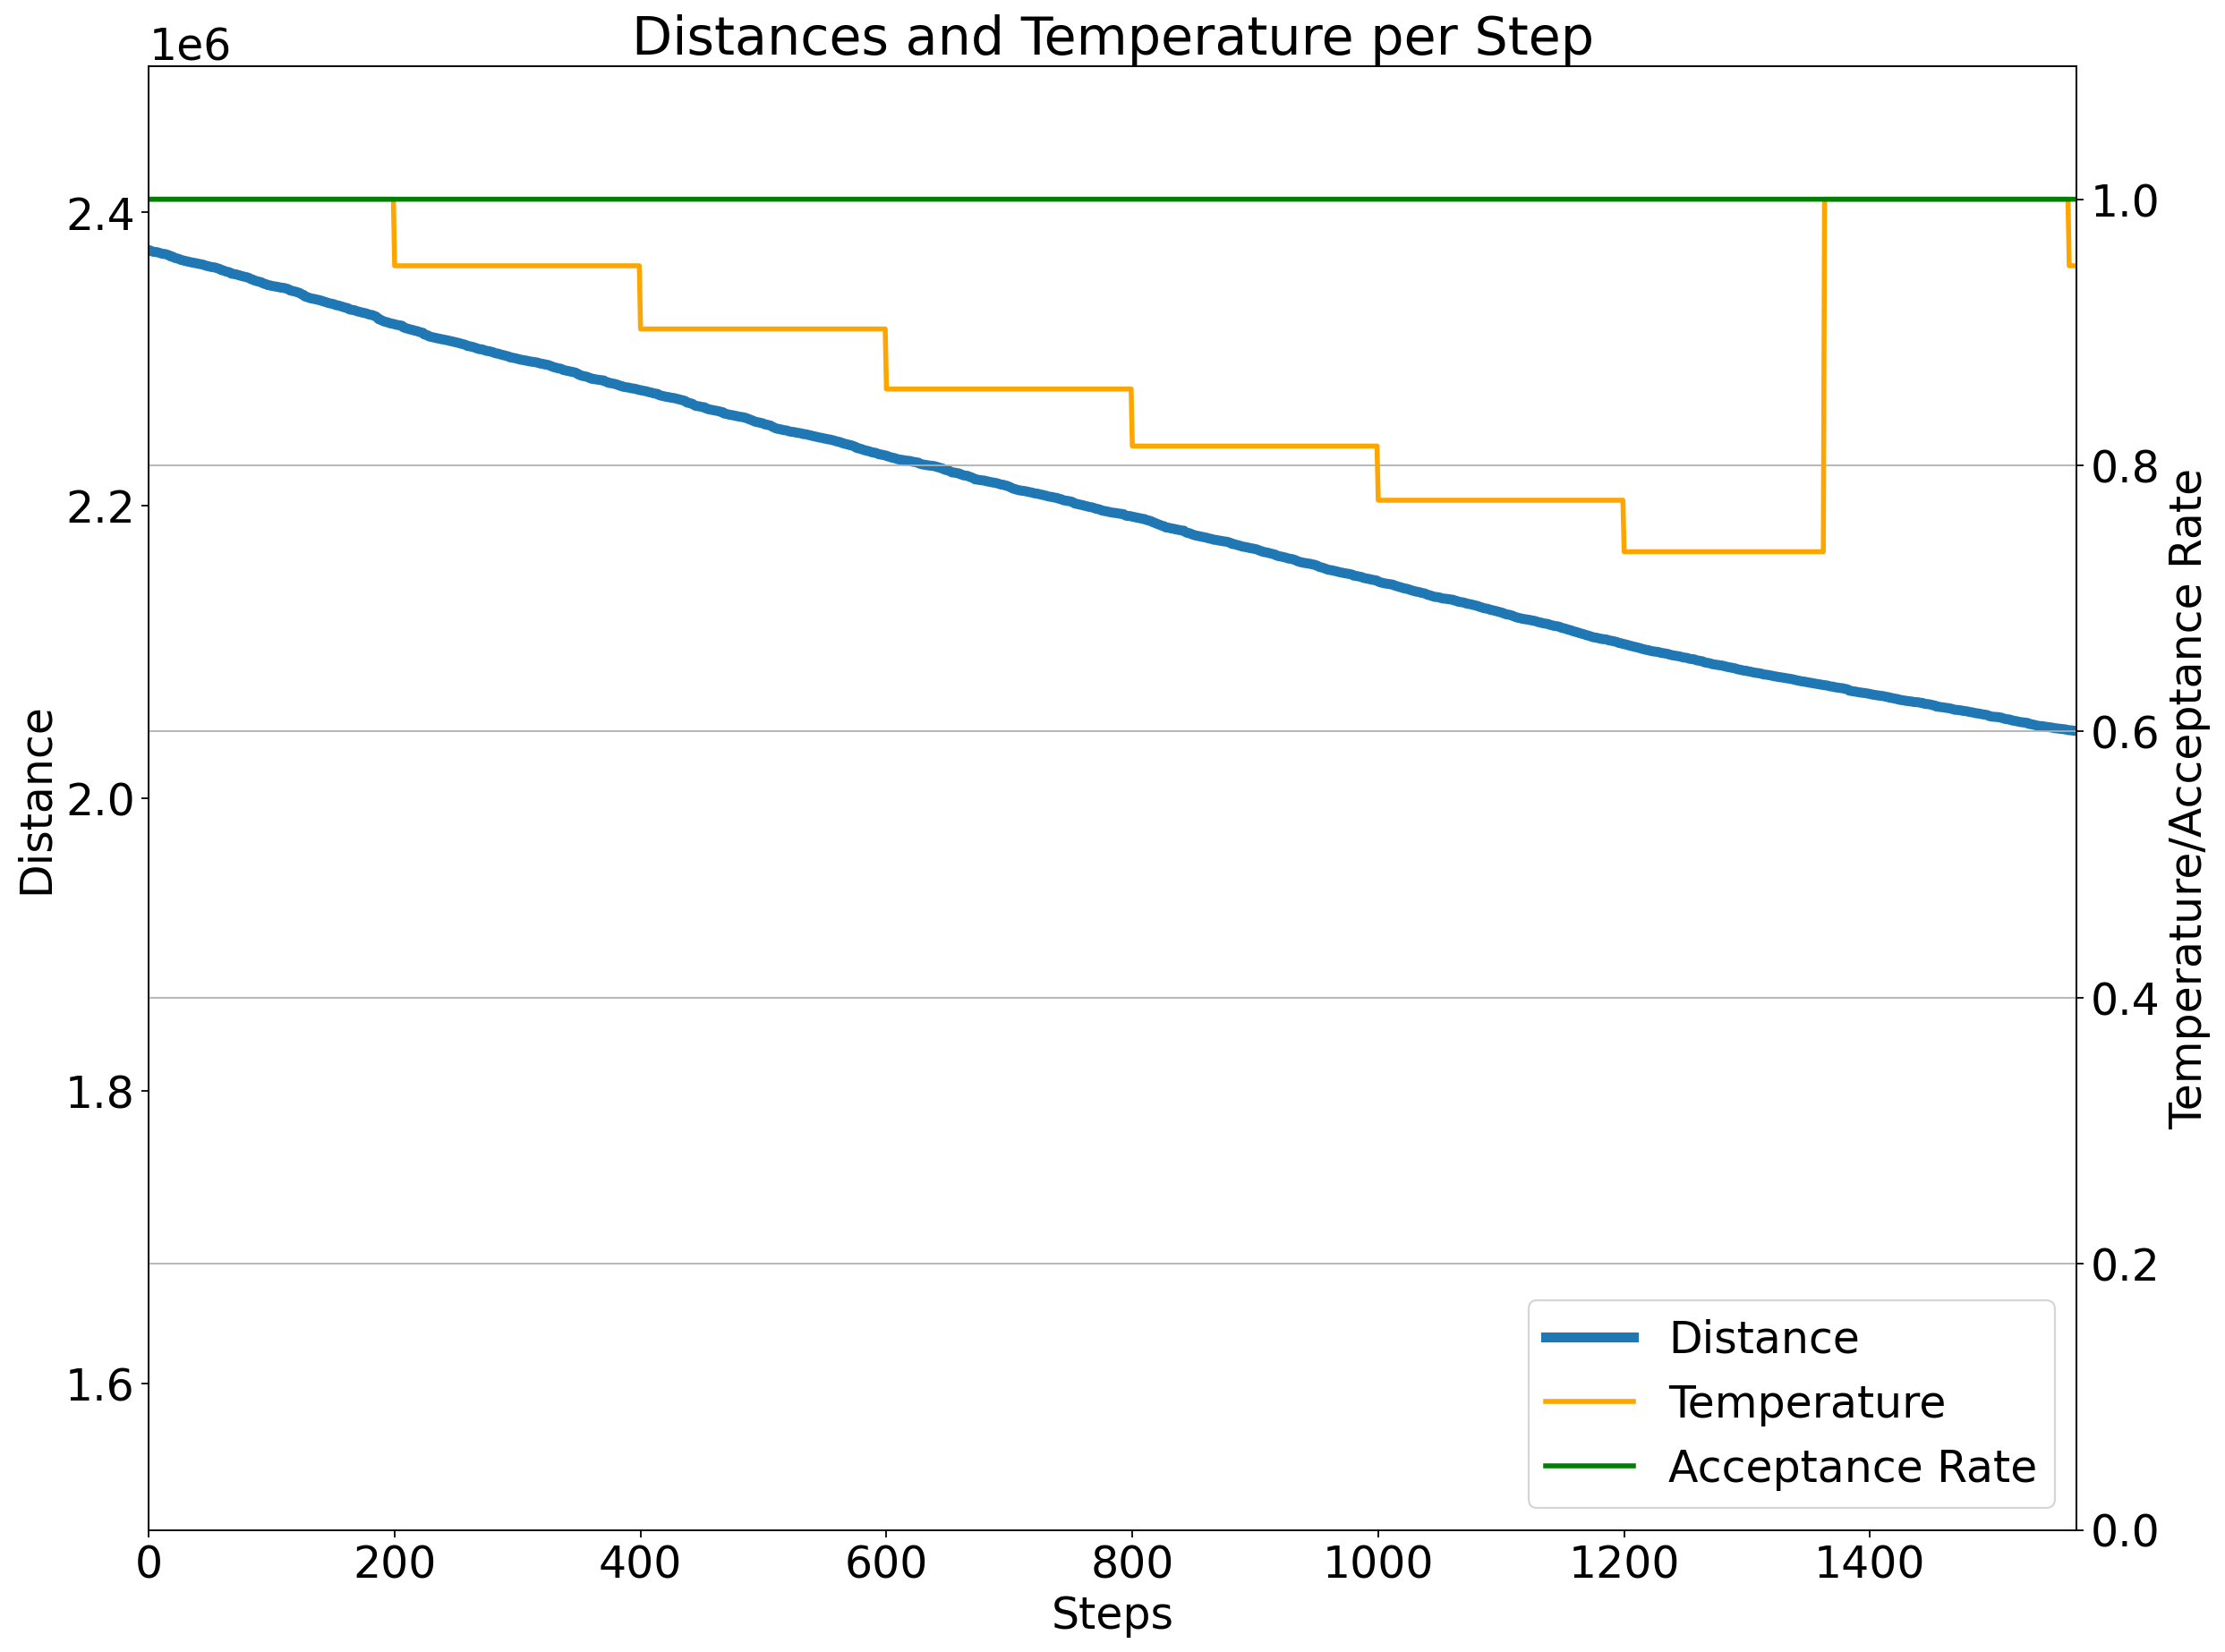

In [9]:
print("test")
solution_stage1b = cl.Solution(temp_depot,dict_tours_temp,list_days,dev_curr=dict_statistic, dev_tot_old =dict_statistic)
solution_stage1b.plot_developement(exp_prefix = img_exp_path + 'solution_stage1b')

In [10]:
print("old distance: %s" % solution_stage1a.total_distance)
print("new distance: %s" % solution_stage1b.total_distance)

old distance: 2077207.3177647186
new distance: 2045841.657024013
